In [276]:
%reset -f

In [277]:
# Import packages
import os
import pandas as pd
from plotnine import *
from scipy.stats import chisquare
import numpy as np
from docx import Document # save summary stats at the end

Load Dataframes & Dictionaries

In [278]:
base_path = os.path.join(os.getcwd(), "CBI Analysis_Actionable Insights")

# Load DFs (RandomForest is now our Default Model)
CBI_tot = pd.read_excel(os.path.join(base_path, "df_CBI_tot_analysis_rf.xlsx"))
CBI_term = pd.read_excel(os.path.join(base_path, "df_CBI_term_analysis_rf.xlsx"))
CBI_tot_corr = pd.read_excel(os.path.join(base_path, "df_CBI_tot_analysis_corr.xlsx"))
CBI_term_corr = pd.read_excel(os.path.join(base_path, "df_CBI_term_analysis_corr.xlsx"))
CBI_tot_unweighted = pd.read_excel(os.path.join(base_path, "df_CBI_analysis.xlsx"))
CBI_term_unweighted = pd.read_excel(os.path.join(base_path, "df_CBI_term_analysis.xlsx"))

# Load Dictionaries (RandomForest is now our Default Model)
weights_tot = pd.read_excel(os.path.join(base_path, "weights_rf_tot_dict.xlsx"), index_col=0).squeeze("columns").to_dict()
weights_term = pd.read_excel(os.path.join(base_path, "weights_rf_dict.xlsx"), index_col=0).squeeze("columns").to_dict()
weights_tot_corr = pd.read_excel(os.path.join(base_path, "weights_corr_tot_dict.xlsx"), index_col=0).squeeze("columns").to_dict()
weights_term_corr = pd.read_excel(os.path.join(base_path, "weights_corr_dict.xlsx"), index_col=0).squeeze("columns").to_dict()
weights_unweighted = {"DR": 1, "OFS": 1, "IAS": 1, "PCS": 1}

In [279]:
# Strategy: label Fall/Spring starting with the same year, to count them as the same academic year
# e.g. Fall 2021 & Spring 2022 will turn into 2021.0 and 2021.5, to group as the 2021 academic year

def semester_order_func(sem):
    season, year = sem.split()
    year = int(year)
    if season == "Fall":
        return year + 0.0           # Fall 2021 turns into 2021.0; Fall 2021 into 2022.0; etc
    elif season == "Spring":
        return (year - 1) + 0.5     # Spring 2022 - 1 + 0.5 = 2021.5 so that it'll follow Fall 2021.0

<h1>Analyzing CBI Total</h1>

CBI by Course 

In [280]:
# CBI Alphabetical
CBI_tot_alphabetical = CBI_tot[["Course Description", "CBI"]].sort_values(by="Course Description")

# CBI Highest to Lowest
CBI_tot_highlow1 = CBI_tot[["Course Description", "CBI"]].sort_values(by="CBI", ascending=False).reset_index(drop=True)

In [281]:
print("CBI Total Summary Stats:\n")

# Mean, median, standard deviation, min, max
cbi_tot_mean = round(CBI_tot["CBI"].mean(), 2)
cbi_tot_median = round(CBI_tot["CBI"].median(), 2)
cbi_tot_std = round(CBI_tot["CBI"].std(), 2)
cbi_tot_min = round(CBI_tot["CBI"].min(), 2)
cbi_tot_max = round(CBI_tot["CBI"].max(), 2)
print(f"Mean CBI: {cbi_tot_mean}")
print(f"Median CBI: {cbi_tot_median}")
print(f"Standard Deviation: {cbi_tot_std}")
print(f"Min CBI: {cbi_tot_min}")
print(f"Max CBI: {cbi_tot_max}")

# Quantiles
q1_cbi_tot = CBI_tot["CBI"].quantile(0.25)
q2_cbi_tot = CBI_tot["CBI"].median()  # or quantile(0.50)
q3_cbi_tot = CBI_tot["CBI"].quantile(0.75)
print("\nScoring Distribution (Quantiles):")
print(f"25% of the data has a CBI below: {q1_cbi_tot}")
print(f"50% of the data has a CBI below: {q2_cbi_tot}")
print(f"75% of the data has a CBI below: {q3_cbi_tot}")

# Top highest and lowest DR courses
high_low_count = 10
top_cbi_tot = CBI_tot.nlargest(high_low_count, "CBI")
bottom_cbi_tot = CBI_tot.nsmallest(high_low_count, "CBI")

print(f"\n{high_low_count} Highest CBI Courses:")
print(top_cbi_tot[["Course Description", "CBI"]])
print(f"\n{high_low_count} Lowest CBI Courses:")
print(bottom_cbi_tot[["Course Description", "CBI"]])

CBI Total Summary Stats:

Mean CBI: 1.41
Median CBI: 1.12
Standard Deviation: 0.67
Min CBI: 0.75
Max CBI: 2.61

Scoring Distribution (Quantiles):
25% of the data has a CBI below: 0.77
50% of the data has a CBI below: 1.12
75% of the data has a CBI below: 2.21

10 Highest CBI Courses:
                Course Description   CBI
33                         Game AI  2.61
65                      STEM Games  2.60
10    Computational Social Science  2.59
32  Foundation of Info & Inference  2.59
57     Natural Language Processing  2.59
46        Intro to Creative Coding  2.58
1              Advanced Web Design  2.57
3    Applied Cyberinfrastruct Conc  2.56
7    Bayesian Modeling & Inference  2.56
55   Monetizing Independent Gaming  2.27

10 Lowest CBI Courses:
                Course Description   CBI
17           Database Dev and Mgmt  0.75
23                Digital Dilemmas  0.75
44  Intellectual Property/Copyrigh  0.75
49              Intro to Info Tech  0.75
59                Online Searching 

Highest CBI Scores (grouped) & all their classes

In [282]:
high_count = 10 # Number of top CBI scores to display

# Group by CBI score and concatenate course descriptions (no need for unique())
tot_top_grouped = (CBI_tot.groupby("CBI")["Course Description"]
    .apply(lambda x: ", ".join(x)) # Concatenate course descriptions
    .reset_index()                 # Reset index to get a DataFrame
    .sort_values(by="CBI", ascending=False) # Sort by CBI score
    .head(high_count)                       # Top N (high_count) CBI scores
    .reset_index(drop=True))

print(f"\nTop {high_count} Highest CBI Scores (Grouped by Score):")
print(tot_top_grouped)



Top 10 Highest CBI Scores (Grouped by Score):
    CBI                                 Course Description
0  2.61                                            Game AI
1  2.60                                         STEM Games
2  2.59  Computational Social Science, Foundation of In...
3  2.58                           Intro to Creative Coding
4  2.57                                Advanced Web Design
5  2.56  Applied Cyberinfrastruct Conc, Bayesian Modeli...
6  2.27                      Monetizing Independent Gaming
7  2.26           Esports Casting, Visual Content Creation
8  2.23                          Intro to Digital Cultures
9  2.22  Designing an Installation, Info Trust and Mani...


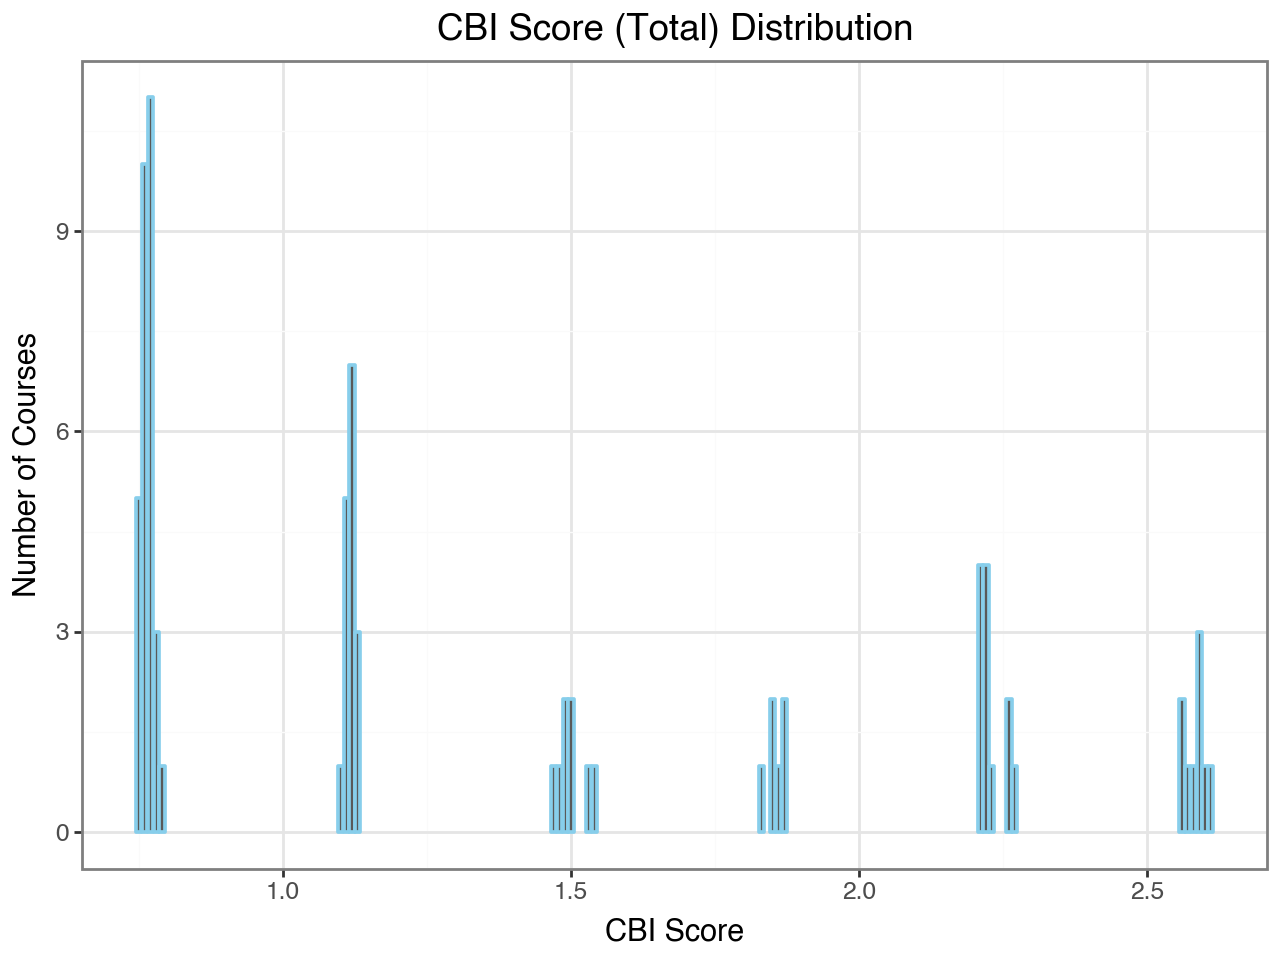

In [283]:
CBI_tot_counts = (ggplot(CBI_tot, aes(x="CBI")) +
    geom_bar(color="skyblue", size=0.75) +
    theme_bw() +
    labs(title="CBI Score (Total) Distribution", x="CBI Score", y="Number of Courses"))

CBI_tot_counts

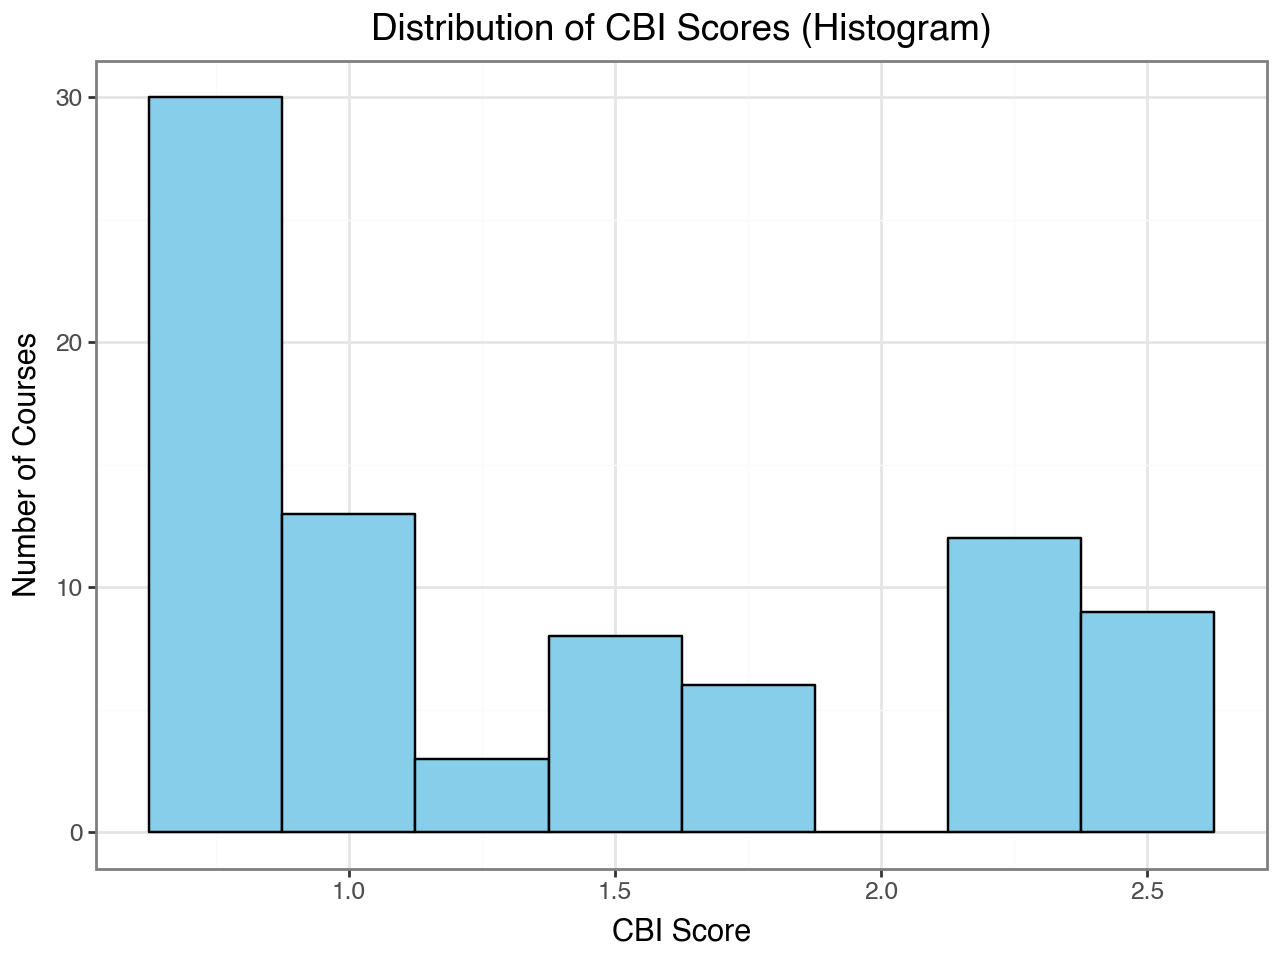

In [284]:
CBI_tot_counts_hist = (ggplot(CBI_tot, aes(x="CBI")) +
    geom_histogram(binwidth=0.25, fill="skyblue", color="black") +
    theme_bw() +
    labs(title="Distribution of CBI Scores (Histogram)", x="CBI Score", y="Number of Courses")
)

CBI_tot_counts_hist


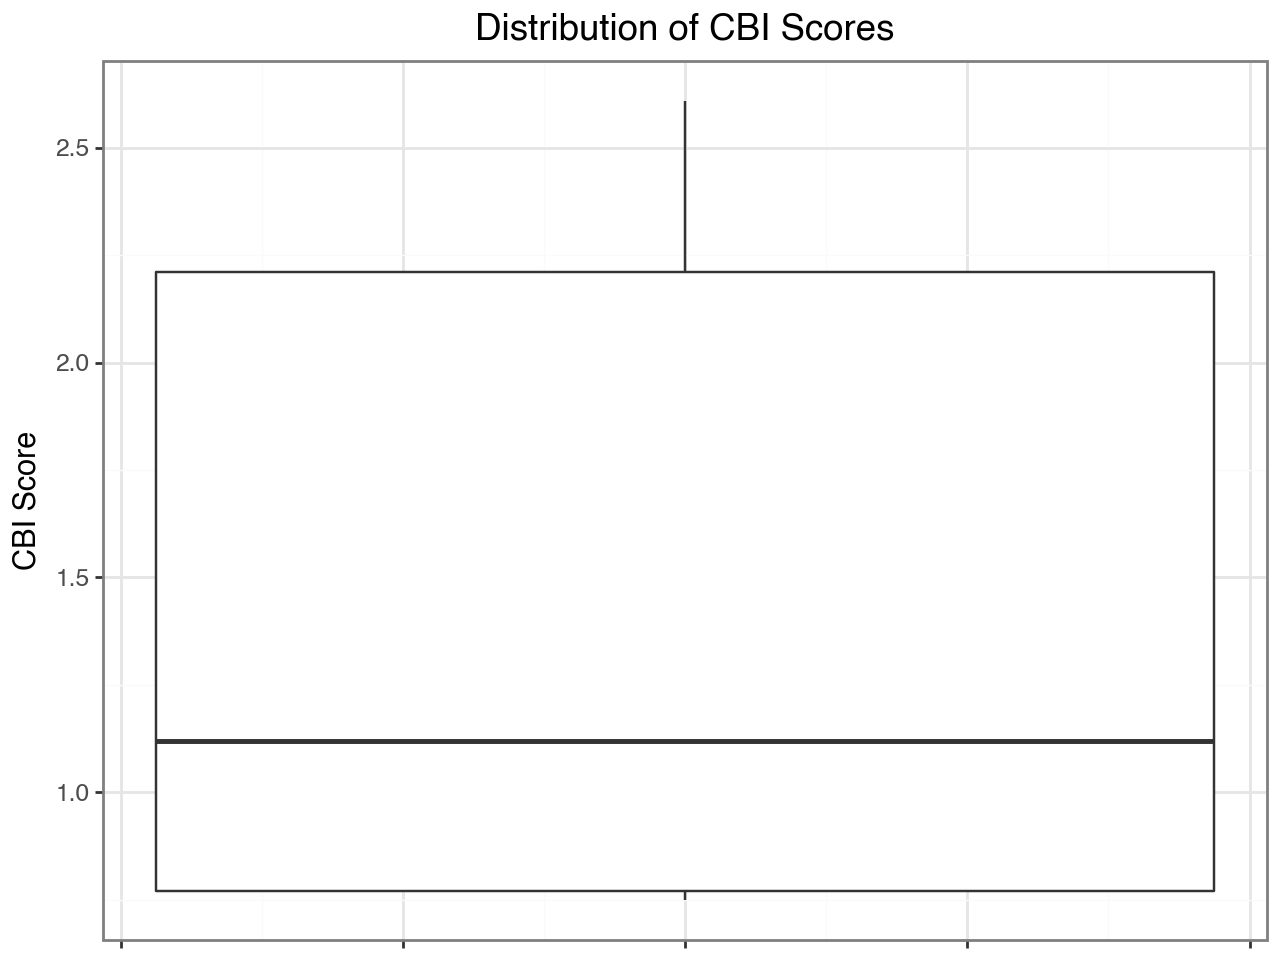

In [285]:
CBI_tot_counts_distro = (ggplot(CBI_tot, aes(y="CBI")) +
    geom_boxplot() +
    theme_bw() +
    labs(title="Distribution of CBI Scores", y="CBI Score") +
    theme(axis_text_x=element_blank())
)

CBI_tot_counts_distro 

<h1>Analyzing CBI by Term</h1>

CBI by Term 
1) Alphabetical by Term (CBI_term_alphabetical)
2) Descending CBI by Term (CBI_tot_highlow)

In [286]:
# CBI Alphabetical
CBI_term_alphabetical = CBI_term[["Term", "Course Description", "CBI"]]

# CBI Highest to Lowest
CBI_term["Term"] = pd.Categorical(CBI_term["Term"], categories=CBI_term["Term"].unique(), ordered=True) # Lock order of Terms
CBI_tot_highlow = (CBI_term[["Term", "Course Description", "CBI"]]
    .sort_values(by=["Term", "CBI"], ascending=[True, False])
    .reset_index(drop=True))

Summary Stats

In [287]:
# For Loop for our summary stats (mean, median, std, min/max) and top/bottom courses

# Empty Lists to store some summary stats for graphing
cbi_term_means = []
cbi_term_medians = []
cbi_term_stds = []

for df_semester, group in CBI_term.groupby("Term", sort=False, observed=True): # sort = False to keep my Terms in academic year order
    # Summary stats (mean, median, std)
    cbi_term_mean = round(group["CBI"].mean(), 2)                           # Mean
    cbi_term_means.append({"Term": df_semester, "Mean CBI": cbi_term_mean}) # Save Mean to cbi_term_means
    cbi_term_median = round(group["CBI"].median(), 2)                             # Median
    cbi_term_medians.append({"Term": df_semester, "Median CBI": cbi_term_median}) # Save Median to cbi_term_medians
    cbi_term_std = round(group["CBI"].std(), 2)
    cbi_term_stds.append({"Term": df_semester, "STD CBI": cbi_term_std})

    # Print summary stats
    print(f"\n🗓 CBI Summary for {df_semester}") # emoji to make it easier to read
    print(f"Mean CBI: {cbi_term_mean}")
    print(f"Median CBI: {cbi_term_median}")
    print(f"Standard Deviation: {cbi_term_std}")

    # Min/Max with course name(s)
    cbi_term_min = round(group["CBI"].min(), 2)
    cbi_term_max = round(group["CBI"].max(), 2)
    cbi_term_course_min = group.loc[group["CBI"] == cbi_term_min, "Course Description"].tolist()
    cbi_term_course_max = group.loc[group["CBI"] == cbi_term_max, "Course Description"].tolist()
    print(f"Min CBI: {cbi_term_min} on Courses: {cbi_term_course_min}")
    print(f"Max CBI: {cbi_term_max} on Courses: {cbi_term_course_max}")

    #Top/Bottom 
    high_low_count = 10
    top_cbi_term = group.nlargest(high_low_count, "CBI")[["Course Description", "CBI"]]
    bottom_cbi_term = group.nsmallest(high_low_count, "CBI")[["Course Description", "CBI"]]
    print(f"\n{df_semester}: {high_low_count} Highest CBI Courses:")
    print(top_cbi_term.to_string(index=False))
    print(f"\n {df_semester}: {high_low_count} Lowest CBI Courses:")
    print(bottom_cbi_term.to_string(index=False))



🗓 CBI Summary for Fall 2021
Mean CBI: 0.96
Median CBI: 0.92
Standard Deviation: 0.44
Min CBI: 0.55 on Courses: ['Online Searching']
Max CBI: 2.01 on Courses: ['Intro to Creative Coding']

Fall 2021: 10 Highest CBI Courses:
            Course Description  CBI
      Intro to Creative Coding 2.01
Foundation of Info & Inference 2.00
           Advanced Web Design 1.96
 Bayesian Modeling & Inference 1.94
 Applied Cyberinfrastruct Conc 1.92
    Instructional Technologies 1.63
     Designing an Installation 1.60
                Special Topics 1.60
      User Interf+Website Dsgn 1.59
Simulation and Problem Solving 1.55

 Fall 2021: 10 Lowest CBI Courses:
            Course Description  CBI
              Online Searching 0.55
              Digital Dilemmas 0.56
Digital Storytelling & Culture 0.56
         Theories of New Media 0.57
Digital Discourse and Identity 0.58
  Collaborating: Online Commun 0.59
         Database Dev and Mgmt 0.59
            Intro to Info Tech 0.59
          Quantitati

<h3>CBI by Term - Which Classes Persistently have High CBI Scores?</h3>

In [288]:
# Filter for high CBI scores (above 1)
trend_persistent_high1 = CBI_term[CBI_term["CBI"] > 1]

# Count how often each course appears
trend_persistent_high1 = (trend_persistent_high1["Course Description"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"}))

# Isolate low counts for Intermittent courses
trend_intermittent_high1 = trend_persistent_high1[trend_persistent_high1["Count"] == 1].reset_index(drop=True)
trend_intermittent2_high1 = trend_persistent_high1[trend_persistent_high1["Count"].isin([1, 2])].reset_index(drop=True)

# Keep Counts 2 & Higher
trend_persistent_high1 = trend_persistent_high1[trend_persistent_high1["Count"] > 1]

print("Courses with Persistent High CBI Scores (Above 1):")
print(trend_persistent_high1)


Courses with Persistent High CBI Scores (Above 1):
                Course Description  Count
0             Algorithms for Games      6
1          Artificial Intelligence      6
2    Ethical Issues in Information      6
3               Princ Data Science      6
4              Science Information      6
5            Intro to Data Science      5
6    Special Topics in Information      5
7                  Neural Networks      5
8                      Applied NLP      5
9       Narrative in Digital Games      4
10           Dig Games and Society      4
11                     Data Ethics      4
12          Government Information      4
13             Installation Design      4
14             Advanced Web Design      3
15                 Esports Casting      3
16     Info Trust and Manipulation      3
17    Computational Social Science      3
18            Business Information      3
19       Intro to Digital Cultures      3
20        Intro to Creative Coding      3
21      Instructional Tec

In [289]:
# Filter for high CBI scores (above 1.25)
trend_persistent_high125 = CBI_term[CBI_term["CBI"] > 1.25]

# Count how often each course appears
trend_persistent_high125 = (trend_persistent_high125["Course Description"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"}))

# Isolate when Count = 1 for Intermittent courses
trend_intermittent_high125 = trend_persistent_high125[trend_persistent_high125["Count"] == 1].reset_index(drop=True)
trend_intermittent2_high125 = trend_persistent_high125[trend_persistent_high125["Count"].isin([1, 2])].reset_index(drop=True)

# Keep Counts 2 & Higher
trend_persistent_high125 = trend_persistent_high125[trend_persistent_high125["Count"] > 1]

print("Courses with Persistent High CBI Scores (Above 1.25):")
print(trend_persistent_high125)

Courses with Persistent High CBI Scores (Above 1.25):
                Course Description  Count
0          Artificial Intelligence      6
1             Algorithms for Games      6
2               Princ Data Science      6
3                      Applied NLP      5
4                  Neural Networks      5
5              Installation Design      4
6      Info Trust and Manipulation      3
7                  Esports Casting      3
8     Computational Social Science      3
9        Intro to Digital Cultures      3
10            Business Information      3
11             Advanced Web Design      3
12        Intro to Creative Coding      3
13      Instructional Technologies      3
14   Bayesian Modeling & Inference      3
15        User Interf+Website Dsgn      2
16                  Special Topics      2
17  Foundation of Info & Inference      2
18       Designing an Installation      2
19                         Game AI      2
20   Applied Cyberinfrastruct Conc      2
21   Monetizing Indepe

In [290]:
# Filter for high CBI scores (above 1.5)
trend_persistent_high15 = CBI_term[CBI_term["CBI"] > 1.5]

# Count how often each course appears
trend_persistent_high15 = (trend_persistent_high15["Course Description"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"}))

# Isolate when Count = 1 for Intermittent courses
trend_intermittent_high15 = trend_persistent_high15[trend_persistent_high15["Count"] == 1].reset_index(drop=True)
trend_intermittent2_high15 = trend_persistent_high15[trend_persistent_high15["Count"].isin([1, 2])].reset_index(drop=True)

# Keep Counts 2 & Higher
trend_persistent_high15 = trend_persistent_high15[trend_persistent_high15["Count"] > 1]

print("Courses with Persistent High CBI Scores (Above 1.5):")
print(trend_persistent_high15)

Courses with Persistent High CBI Scores (Above 1.5):
                Course Description  Count
0              Advanced Web Design      3
1         Intro to Creative Coding      3
2      Info Trust and Manipulation      3
3                  Esports Casting      3
4     Computational Social Science      3
5             Business Information      3
6        Intro to Digital Cultures      3
7       Instructional Technologies      3
8    Bayesian Modeling & Inference      3
9                   Special Topics      2
10        User Interf+Website Dsgn      2
11   Applied Cyberinfrastruct Conc      2
12  Foundation of Info & Inference      2
13       Designing an Installation      2
14                         Game AI      2
15   Monetizing Independent Gaming      2
16                      STEM Games      2
17           Special Topics in LIS      2


In [291]:
# Filter for high CBI scores (above 1.75)
trend_persistent_high175 = CBI_term[CBI_term["CBI"] > 1.75]

# Count how often each course appears
trend_persistent_high175 = (trend_persistent_high175["Course Description"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"}))

# Isolate when Count = 1 for Intermittent courses
trend_intermittent_high175 = trend_persistent_high175[trend_persistent_high175["Count"] == 1].reset_index(drop=True)
trend_intermittent2_high175 = trend_persistent_high175[trend_persistent_high175["Count"].isin([1, 2])].reset_index(drop=True)

# Keep Counts 2 & Higher
trend_persistent_high175 = trend_persistent_high175[trend_persistent_high175["Count"] > 1]

print("Courses with Persistent High CBI Scores (Above 1.75):")
print(trend_persistent_high175)

Courses with Persistent High CBI Scores (Above 1.75):
               Course Description  Count
0             Advanced Web Design      3
1   Bayesian Modeling & Inference      3
2        Intro to Creative Coding      3
3    Computational Social Science      3
4   Applied Cyberinfrastruct Conc      2
5  Foundation of Info & Inference      2
6                         Game AI      2
7                      STEM Games      2


<h3>CBI by Term - Courses with Intermittent High CBI Scores </h3>

In [292]:
print("Courses with 1-2 Intermittent High CBI Scores (Above 1):")
print(trend_intermittent2_high1)

print("\nCourses with 1-2 Intermittent High CBI Scores (Above 1):")
print(trend_intermittent2_high125)

print("\nCourses with 1-2 Intermittent High CBI Scores (Above 1.5):")
print(trend_intermittent2_high15)

print("\nCourses with 1-2 Intermittent High CBI Scores (Above 1.75):")
print(trend_intermittent2_high175)

Courses with 1-2 Intermittent High CBI Scores (Above 1):
                Course Description  Count
0         User Interf+Website Dsgn      2
1                   Special Topics      2
2   Foundation of Info & Inference      2
3        Designing an Installation      2
4                          Game AI      2
5    Applied Cyberinfrastruct Conc      2
6    Monetizing Independent Gaming      2
7                       STEM Games      2
8            Special Topics in LIS      2
9   Simulation and Problem Solving      1
10     Natural Language Processing      1
11         Visual Content Creation      1

Courses with 1-2 Intermittent High CBI Scores (Above 1):
                Course Description  Count
0         User Interf+Website Dsgn      2
1                   Special Topics      2
2   Foundation of Info & Inference      2
3        Designing an Installation      2
4                          Game AI      2
5    Applied Cyberinfrastruct Conc      2
6    Monetizing Independent Gaming      2
7  

In [293]:
print("Courses with 1 Intermittent High CBI Scores (Above 1):")
print(trend_intermittent_high1)

print("\nCourses with 1 Intermittent High CBI Scores (Above 1.25):")
print(trend_intermittent_high125)

print("\nCourses with 1 Intermittent High CBI Scores (Above 1.5):")
print(trend_intermittent_high15)

print("\nCourses with 1 Intermittent High CBI Scores (Above 1.75):")
print(trend_intermittent_high175)

Courses with 1 Intermittent High CBI Scores (Above 1):
               Course Description  Count
0  Simulation and Problem Solving      1
1     Natural Language Processing      1
2         Visual Content Creation      1

Courses with 1 Intermittent High CBI Scores (Above 1.25):
               Course Description  Count
0  Simulation and Problem Solving      1
1     Natural Language Processing      1
2         Visual Content Creation      1

Courses with 1 Intermittent High CBI Scores (Above 1.5):
               Course Description  Count
0  Simulation and Problem Solving      1
1     Natural Language Processing      1
2                 Neural Networks      1
3         Visual Content Creation      1

Courses with 1 Intermittent High CBI Scores (Above 1.75):
            Course Description  Count
0  Natural Language Processing      1


<h3>CBI By Course & Term - Change Analysis by Term</h3>

In [294]:
# Lock the order of Terms
CBI_term_delta = CBI_term.copy()
CBI_term_delta["Term"] = pd.Categorical(CBI_term_delta["Term"], categories=CBI_term_delta["Term"].unique(), ordered=True)

# Calculate Delta: Add New Col, Group by Course, .diff() goes in order of the DF so it'll calculate in Academdic calendar year order 
CBI_term_delta["Delta"] = CBI_term_delta.groupby("Course Description")["CBI"].diff().round(3)

# Pivot: Make the Deltas by Term into Columns
CBI_term_delta = (CBI_term_delta.pivot(index="Course Description", columns="Term", values="Delta")
    .reset_index())
CBI_term_delta = CBI_term_delta.drop(columns=["Fall 2021"]) # Drop Fall 2021 because it has no previous term to compare to

# Rename Columns to Delta_Term
CBI_term_delta.columns = ["Course Description"] + [f"Delta_{term}" for term in CBI_term_delta.columns[1:]]

In [295]:
# Melt the DataFrame for Graphing
cbi_term_delta_graphdf = CBI_term_delta.melt(id_vars="Course Description", var_name="Delta_Term", value_name="CBI Delta")

/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 166 rows containing missing values.


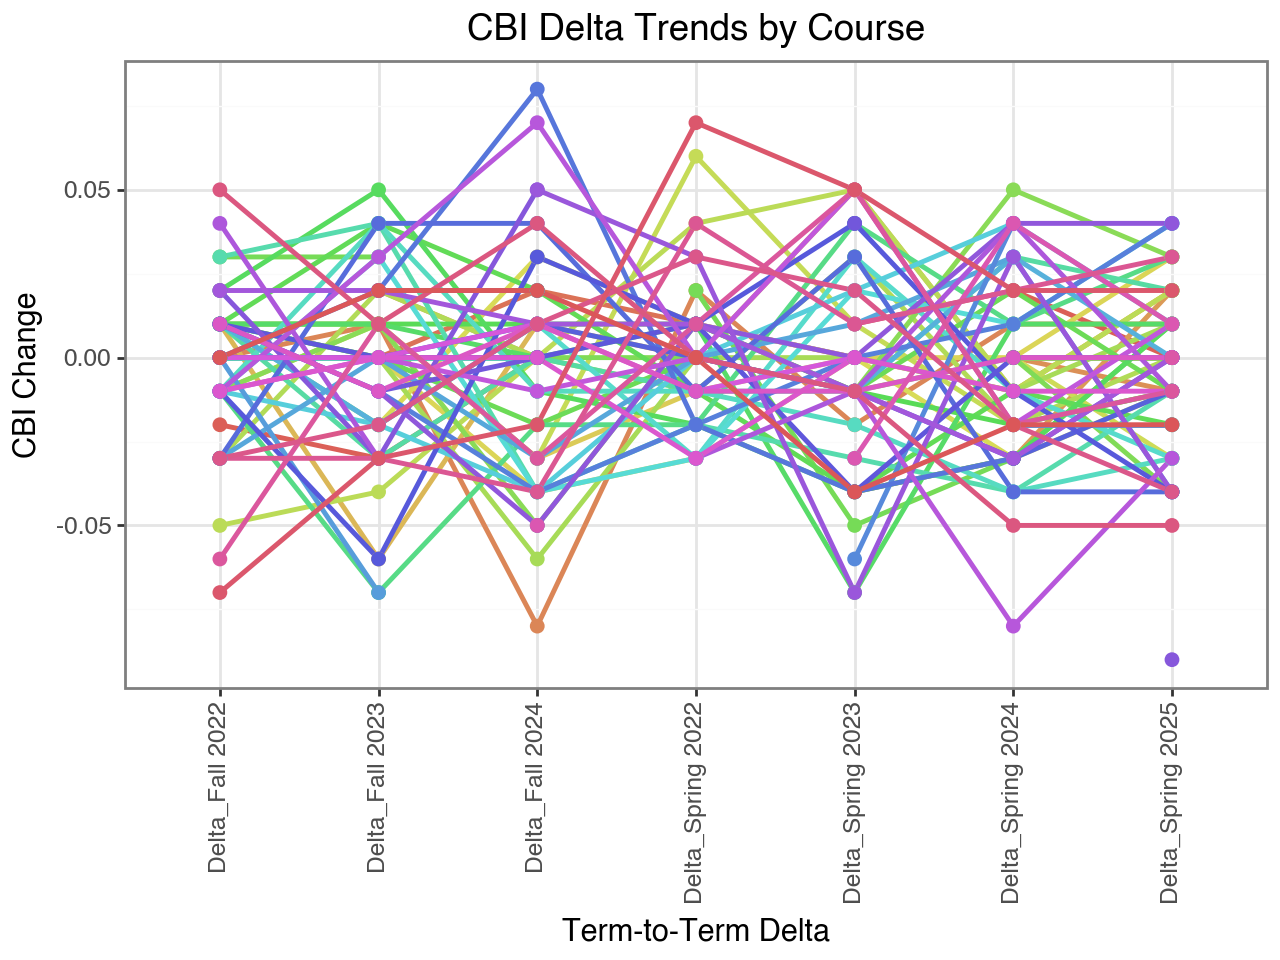

In [296]:
CBI_term_delta_graph_all = (ggplot(cbi_term_delta_graphdf, 
                                   aes(x="Delta_Term", y="CBI Delta", group="Course Description", color="Course Description")) +
                            geom_line(size=1) +
                            geom_point(size=2) +
                            theme_bw() +
                            labs(title="CBI Delta Trends by Course", x="Term-to-Term Delta", y="CBI Change") +
                            theme(axis_text_x=element_text(rotation=90, ha='center'),  # centered x-axis labels
                                  legend_position="none"))

CBI_term_delta_graph_all


Isolate by Our Persistent Issue Courses

In [297]:
# Filter for Persistent High CBI Scores (Above 1.5) from trend_persistent_high15
cbi_term_delta_graphdf_persistenthigh = cbi_term_delta_graphdf[cbi_term_delta_graphdf["Course Description"].isin(trend_persistent_high15["Course Description"])]

/opt/anaconda3/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 6 rows containing missing values.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 99 rows containing missing values.


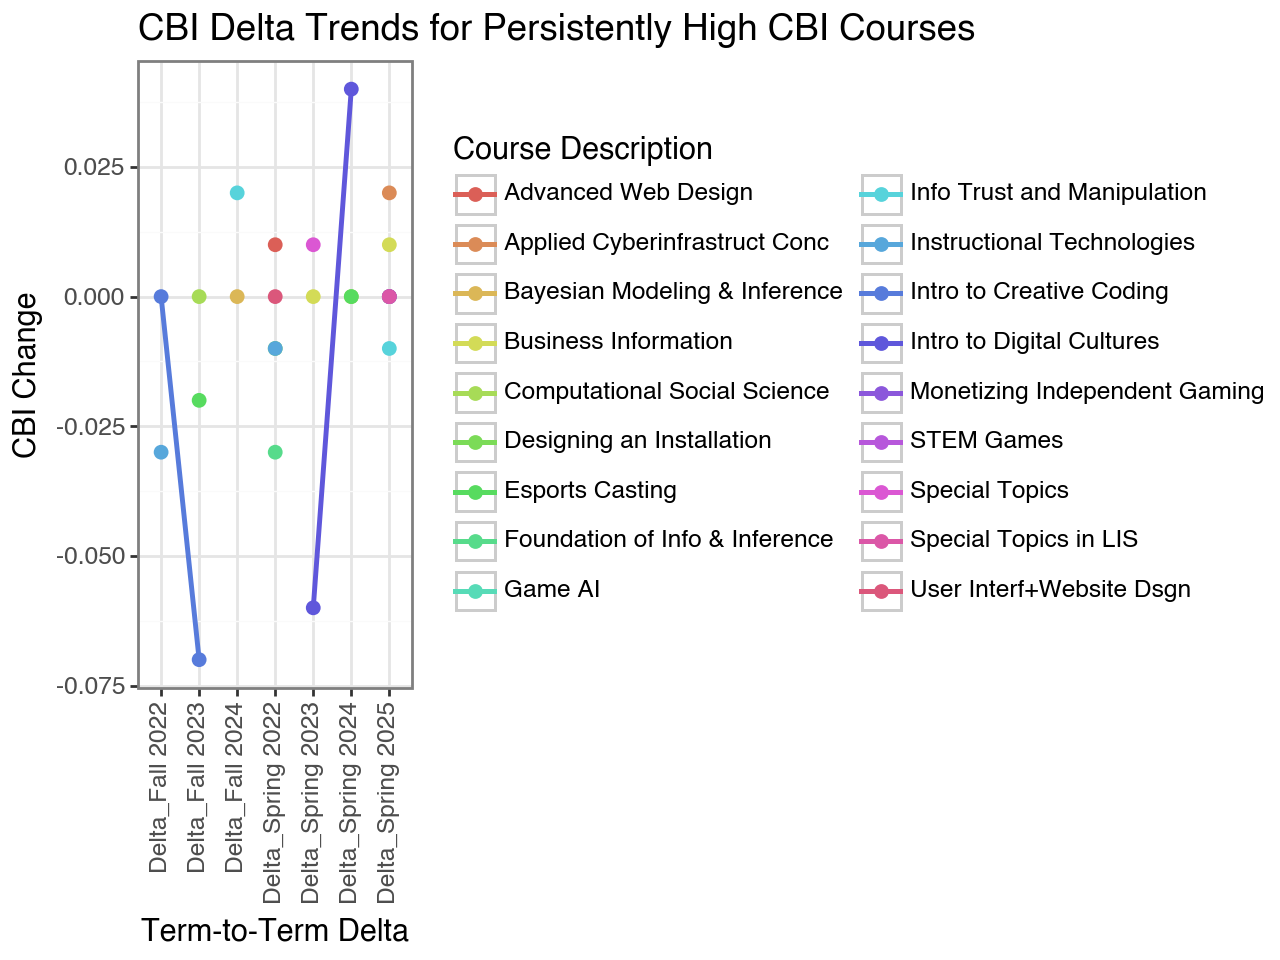

In [298]:
CBI_term_delta_graph_persistenthigh = (ggplot(cbi_term_delta_graphdf_persistenthigh, 
                                              aes(x="Delta_Term", y="CBI Delta", group="Course Description", color="Course Description")) +
                                       geom_line(size=1) +
                                       geom_point(size=2) +
                                       theme_bw() +
                                    labs(title="CBI Delta Trends for Persistently High CBI Courses", x="Term-to-Term Delta", y="CBI Change") +
                                    theme(plot_title=element_text(ha='left'), axis_text_x=element_text(rotation=90, ha='center')))

CBI_term_delta_graph_persistenthigh

We do not have great trend data for our Presistently High CBI courses. This is likely driven by OFS: if the course isn't offered regularly, we can't calculate the deltas.

<h3>CBI by Term - Trend Analysis</h3>

In [299]:
# Lists from Summary Stats - convert to DFs for graphing
df_means = pd.DataFrame(cbi_term_means, columns=["Term", "Mean CBI"])
df_medians = pd.DataFrame(cbi_term_medians, columns=["Term", "Median CBI"])
df_stds = pd.DataFrame(cbi_term_stds, columns=["Term", "STD CBI"])

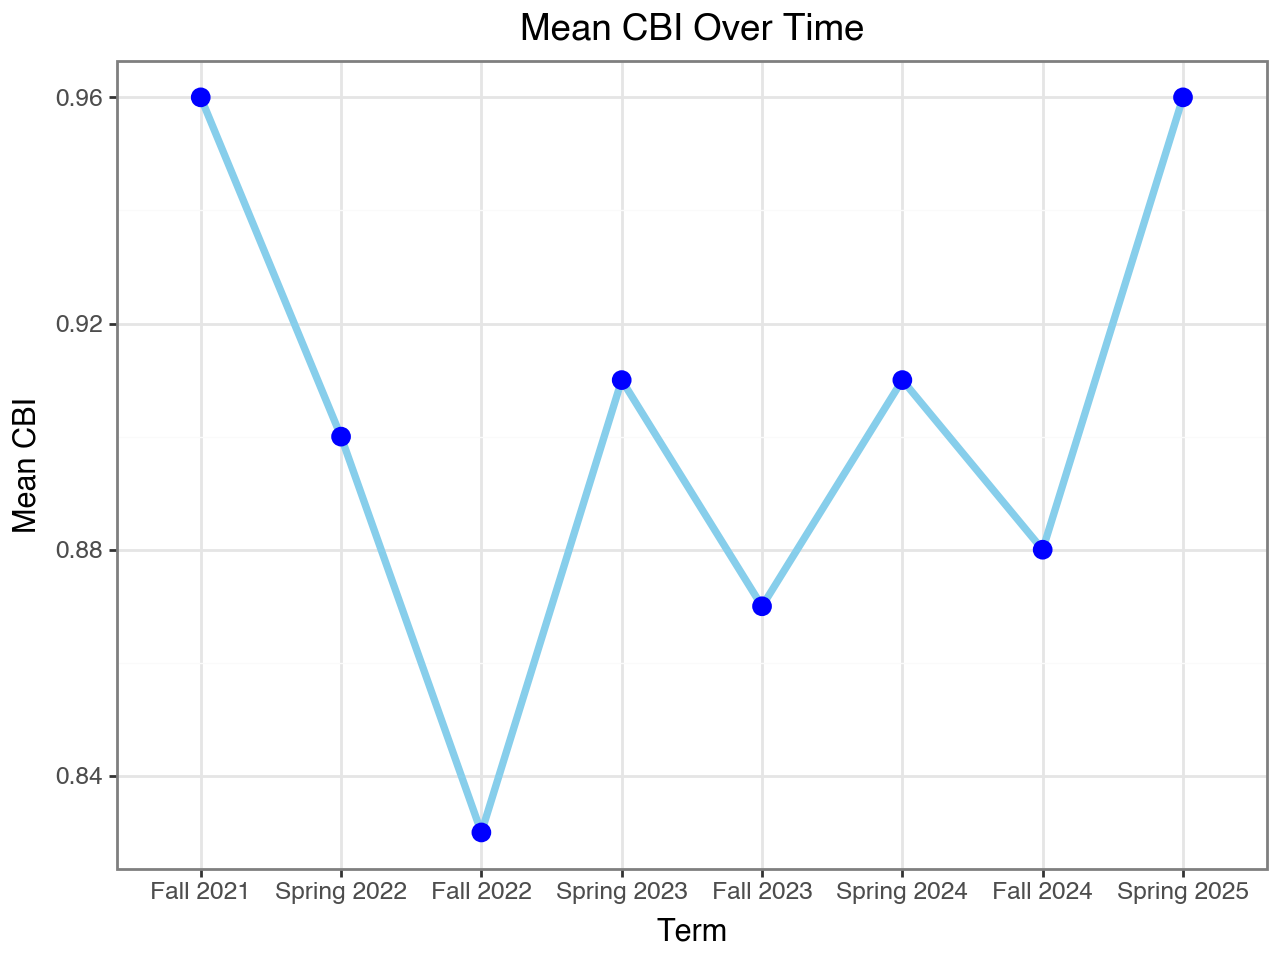

In [300]:
# Lock Terms in order
df_means["Term"] = pd.Categorical(df_means["Term"], categories=df_means["Term"], ordered=True)

trend_term_means = (ggplot(df_means, aes(x="Term", y="Mean CBI", group=1)) +
    geom_line(color="skyblue", size=1.5) + 
    geom_point(color="blue", size=3) + 
    theme_bw() +
    labs(title="Mean CBI Over Time", x="Term", y="Mean CBI") +
    theme(axis_text_x=element_text(hjust=0.5))
)

trend_term_means

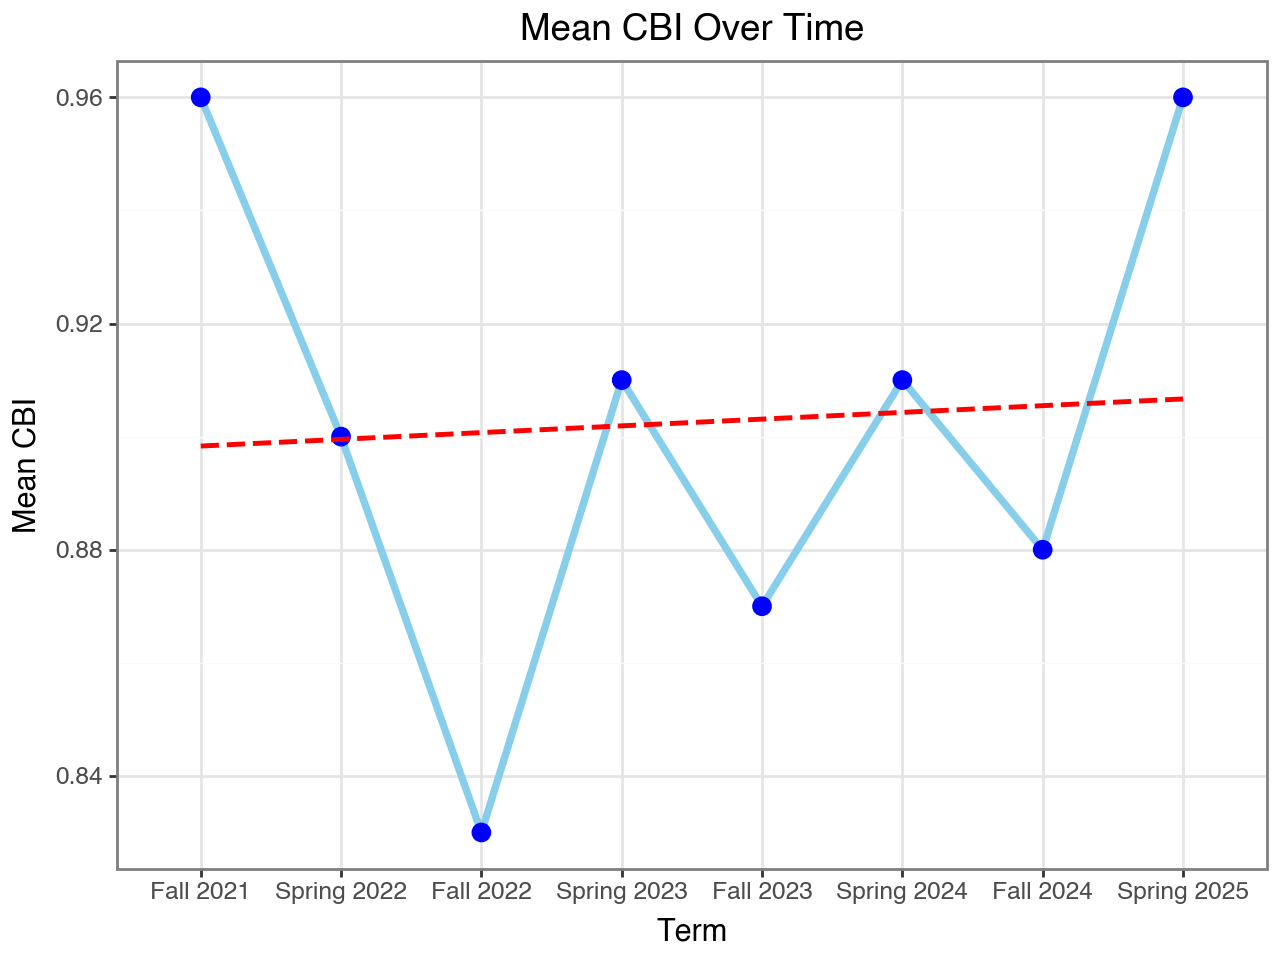

In [301]:
trend_term_means_lm = trend_term_means + geom_smooth(method='lm', color="red", linetype="dashed", se=False)
trend_term_means_lm

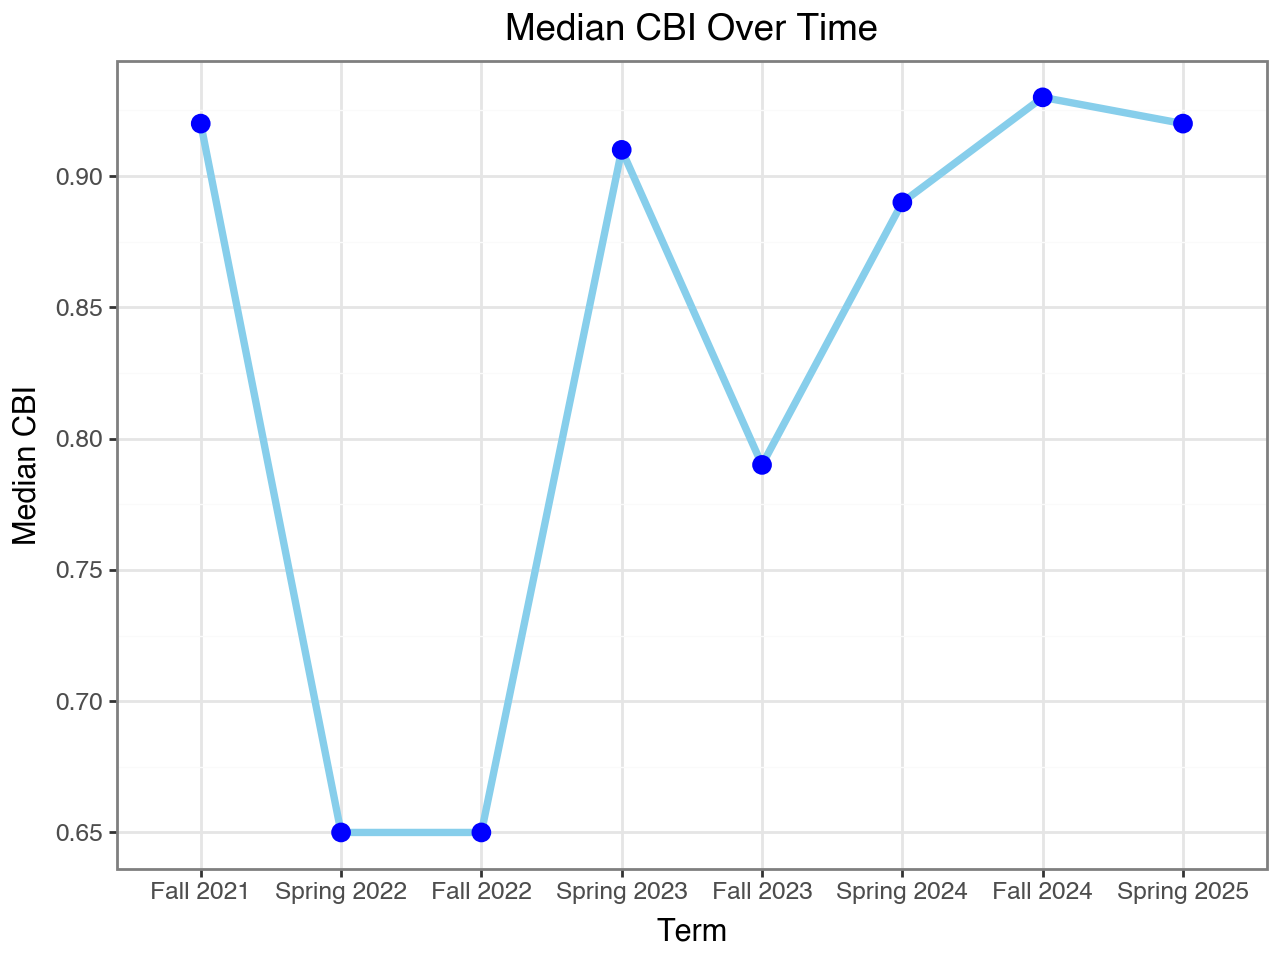

In [302]:
# Lock Terms in order
df_medians["Term"] = pd.Categorical(df_medians["Term"], categories=df_medians["Term"], ordered=True)

trend_term_median = (ggplot(df_medians, aes(x="Term", y="Median CBI", group=1)) +
    geom_line(color="skyblue", size=1.5) + 
    geom_point(color="blue", size=3) + 
    theme_bw() +
    labs(title="Median CBI Over Time", x="Term", y="Median CBI") +
    theme(axis_text_x=element_text(hjust=0.5))
)

trend_term_median

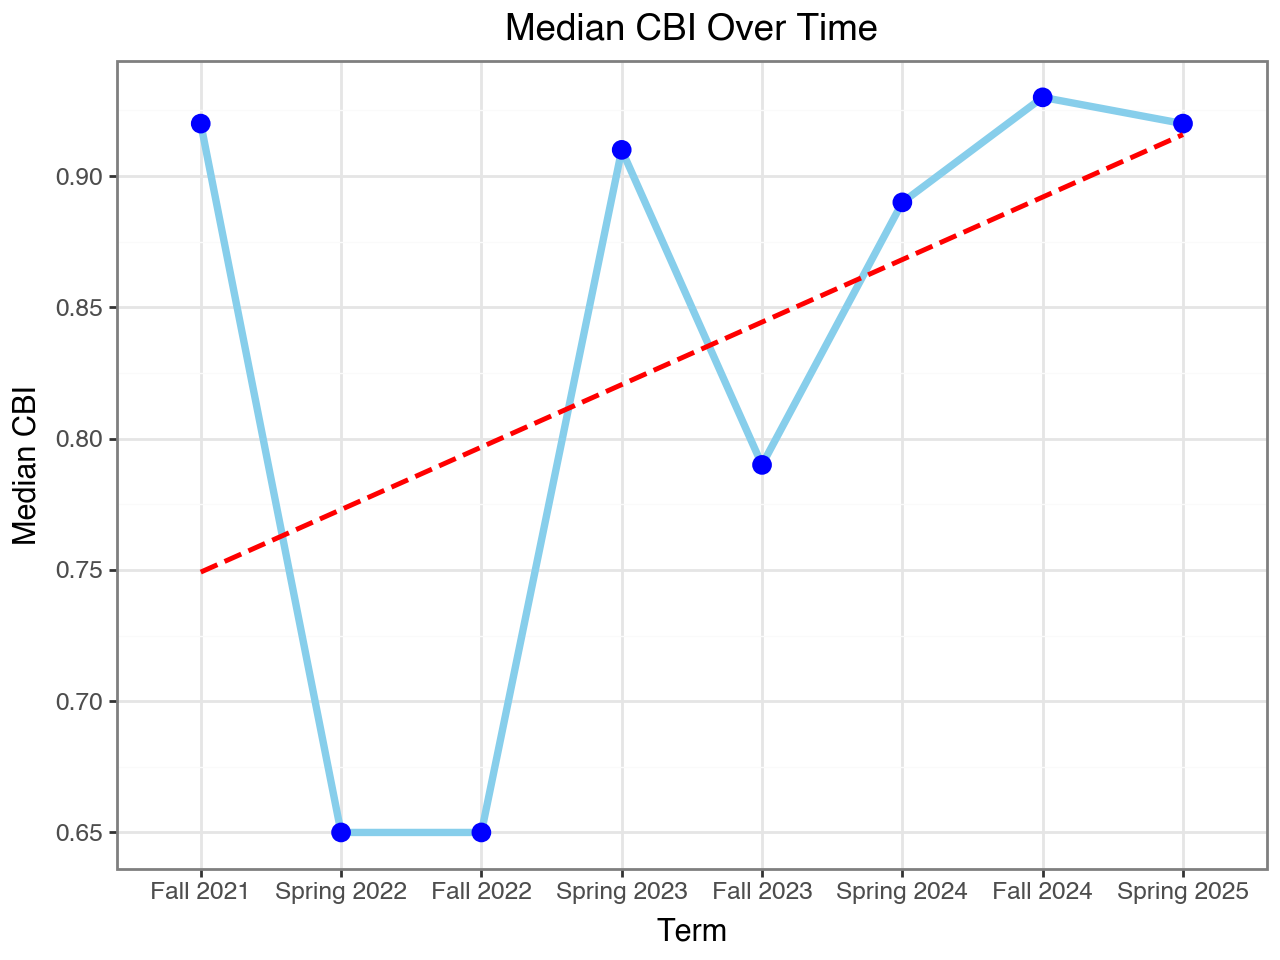

In [303]:
trend_term_median_lm = trend_term_median + geom_smooth(method='lm', color="red", linetype="dashed", se=False)
trend_term_median_lm

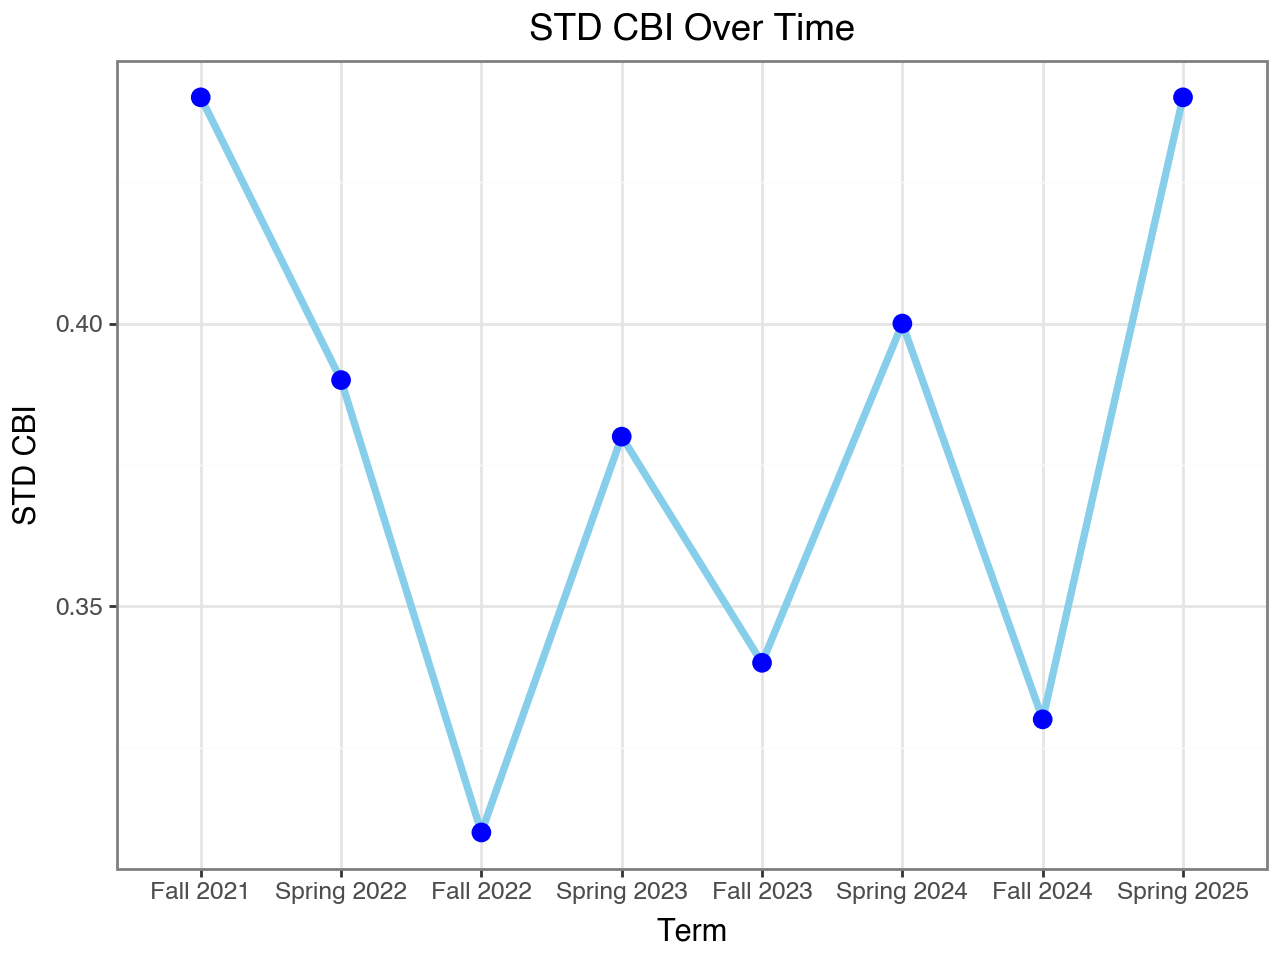

In [304]:
# Lock Terms in order
df_stds["Term"] = pd.Categorical(df_stds["Term"], categories=df_stds["Term"], ordered=True)

trend_term_std = (ggplot(df_stds, aes(x="Term", y="STD CBI", group=1)) +
    geom_line(color="skyblue", size=1.5) + 
    geom_point(color="blue", size=3) + 
    theme_bw() +
    labs(title="STD CBI Over Time", x="Term", y="STD CBI") +
    theme(axis_text_x=element_text(hjust=0.5))
)

trend_term_std

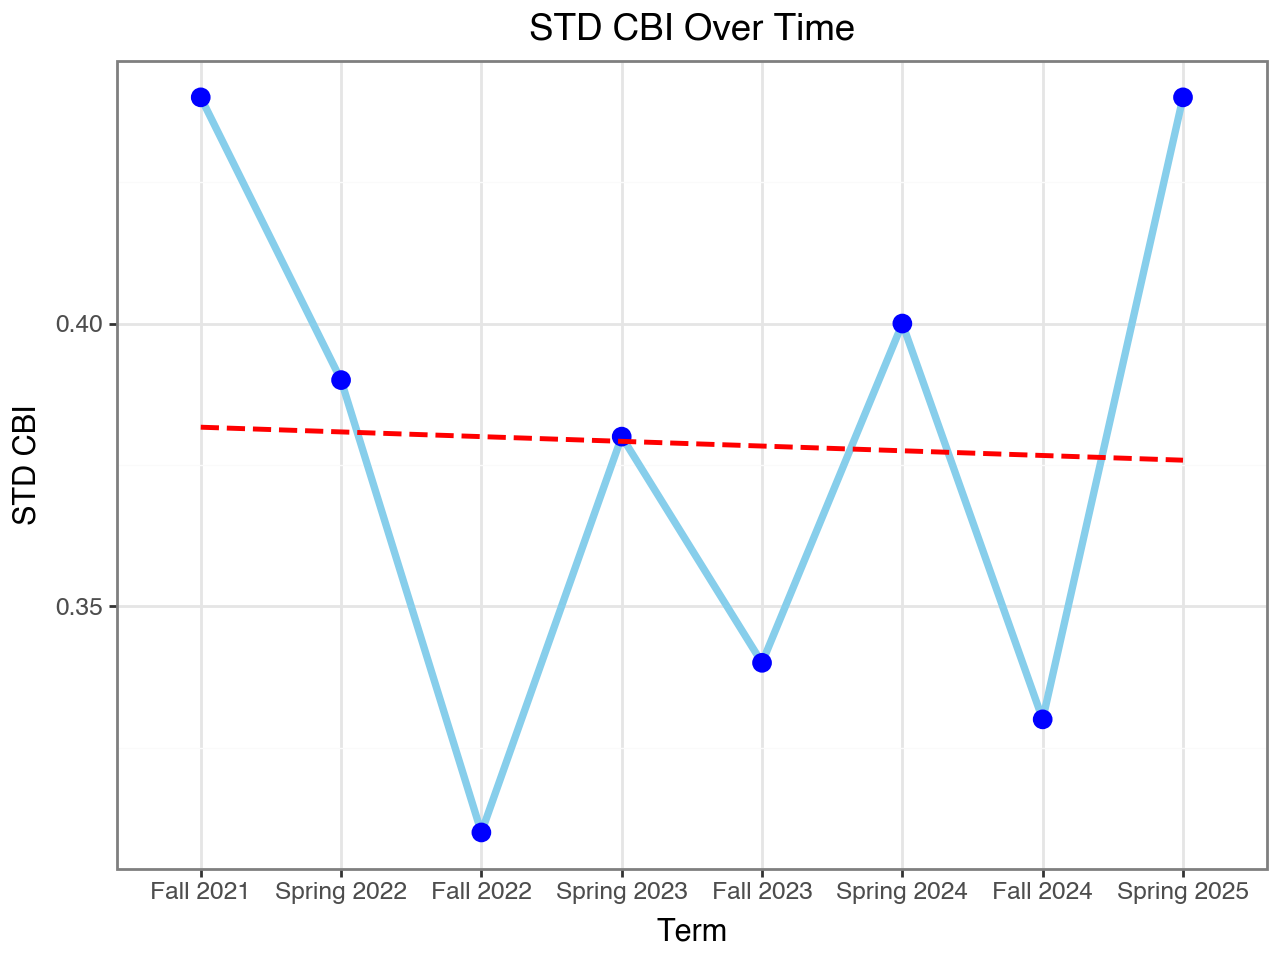

In [305]:
trend_term_std_lm = trend_term_std + geom_smooth(method='lm', color="red", linetype="dashed", se=False)
trend_term_std_lm

<h1>Factor Analysis</h1>

<h2>Factor Analysis - Total</h2>

In [306]:
CBI_tot_factor = CBI_tot.copy()

# Sort the contributions for each course (which factor has the highest weighted score)
factors_ranked_list = (CBI_tot_factor[["DR", "OFS", "IAS", "PCS"]]
                       .apply(lambda row: row.sort_values(ascending=False).index.tolist(), axis=1))

# Make the ranked columns
CBI_tot_factor["Top_Contributor"] = factors_ranked_list.apply(lambda x: x[0])
CBI_tot_factor["Second_Contributor"] = factors_ranked_list.apply(lambda x: x[1])
CBI_tot_factor["Third_Contributor"] = factors_ranked_list.apply(lambda x: x[2])
CBI_tot_factor["Fourth_Contributor"] = factors_ranked_list.apply(lambda x: x[3])

In [307]:
# Print counts for each rank
print("Top Contributor Counts:")
print(CBI_tot_factor["Top_Contributor"].value_counts())

print("\nSecond Contributor Counts:")
print(CBI_tot_factor["Second_Contributor"].value_counts())

print("\nThird Contributor Counts:")
print(CBI_tot_factor["Third_Contributor"].value_counts())

print("\nFourth Contributor Counts:")
print(CBI_tot_factor["Fourth_Contributor"].value_counts())


Top Contributor Counts:
Top_Contributor
OFS    81
Name: count, dtype: int64

Second Contributor Counts:
Second_Contributor
DR     28
IAS    27
PCS    26
Name: count, dtype: int64

Third Contributor Counts:
Third_Contributor
DR     43
IAS    33
PCS     5
Name: count, dtype: int64

Fourth Contributor Counts:
Fourth_Contributor
PCS    50
IAS    21
DR     10
Name: count, dtype: int64


In [308]:
# Filter to top 10 CBI scores
CBI_tot_factor_top10 = CBI_tot_factor.nlargest(10, "CBI")

# Print counts for each rank among Top 10
print("Top Contributor Counts (Top 10 CBI):")
print(CBI_tot_factor_top10["Top_Contributor"].value_counts())

print("\nSecond Contributor Counts (Top 10 CBI):")
print(CBI_tot_factor_top10["Second_Contributor"].value_counts())

print("\nThird Contributor Counts (Top 10 CBI):")
print(CBI_tot_factor_top10["Third_Contributor"].value_counts())

print("\nFourth Contributor Counts (Top 10 CBI):")
print(CBI_tot_factor_top10["Fourth_Contributor"].value_counts())


Top Contributor Counts (Top 10 CBI):
Top_Contributor
OFS    10
Name: count, dtype: int64

Second Contributor Counts (Top 10 CBI):
Second_Contributor
IAS    5
PCS    5
Name: count, dtype: int64

Third Contributor Counts (Top 10 CBI):
Third_Contributor
PCS    4
DR     4
IAS    2
Name: count, dtype: int64

Fourth Contributor Counts (Top 10 CBI):
Fourth_Contributor
DR     6
IAS    3
PCS    1
Name: count, dtype: int64


Graph It

In [309]:
# New DF to Graph, leveraging counts code from above
cbi_contributor_counts = pd.concat([
    CBI_tot_factor["Top_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Top"),
    CBI_tot_factor["Second_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Second"),
    CBI_tot_factor["Third_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Third"),
    CBI_tot_factor["Fourth_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Fourth"),], ignore_index=True)


# Order levels for the x-axis: "Top", "Second", "Third", "Fourth"
cbi_contributor_counts["Level"] = pd.Categorical(cbi_contributor_counts["Level"], 
                                                 categories=["Top", "Second", "Third", "Fourth"], ordered=True)


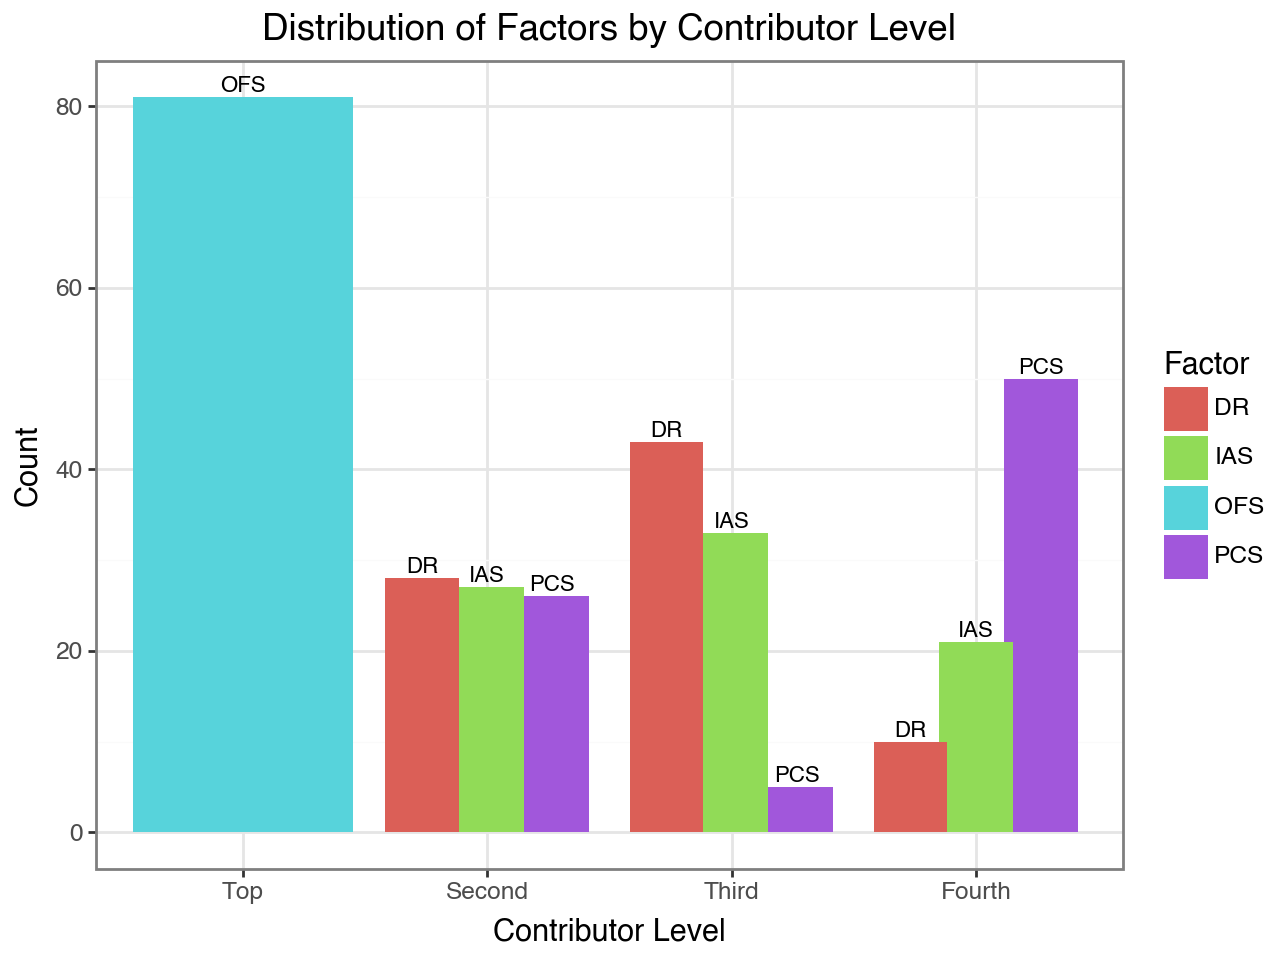

In [310]:
cbi_contributor_graph = (ggplot(cbi_contributor_counts, aes(x="Level", y="Count", fill="Factor")) +
                         # Grouped bar chart, use position_dodge
                         geom_bar(stat="identity", position=position_dodge(width=0.8)) +
                         # Add Factor labels on top of bars
                         geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +
                         theme_bw() +
                         labs(title="Distribution of Factors by Contributor Level", x="Contributor Level", y="Count") +
                         theme(axis_text_x=element_text(ha='center'), legend_title=element_text(text="Factor")))

cbi_contributor_graph


Top Contributor: OFS for 100% of the Classes

Test Top Contributors for Statistical Significance: Is the way factors show up across 2nd-, 3rd-, or 4th-contributors random, or is a real pattern happening?

H0: The second (or third, fourth) contributor is equally likely to be DR, IAS, or PCS.

H1: The second (or third, fourth) contributor is not equally distributed across factors.

In [311]:
# Analyze Contributors for Chi-square test

# Expected if equal
expected_factor_spread = [27, 27, 27]

# Analyze Second Contributors
observed_second = [28, 27, 26]  # Second Contributor Counts: DR, IAS, PCS
# Second Contributors Chi-square test
chi2_stat_second, p_value_second = chisquare(f_obs=observed_second, f_exp=expected_factor_spread)

# Analyze Third Contributors
observed_third = [43, 33, 5]  # PCS, IAS, DR
chi2_stat_third, p_value_third = chisquare(f_obs=observed_third, f_exp=expected_factor_spread)

# Analyze Fourth Contributors
observed_fourth = [50, 21, 10]  # DR, IAS, PCS
chi2_stat_fourth, p_value_fourth = chisquare(f_obs=observed_fourth, f_exp=expected_factor_spread)

print(f"Second Contributors: chi2 = {chi2_stat_second:.4f}, p = {p_value_second:.4f}")
print(f"Third Contributors: chi2 = {chi2_stat_third:.4f}, p = {p_value_third:f}")
print(f"Fourth Contributors: chi2 = {chi2_stat_fourth:.4f}, p = {p_value_fourth:.2e}") #scientific notation, very small

Second Contributors: chi2 = 0.0741, p = 0.9636
Third Contributors: chi2 = 28.7407, p = 0.000001
Fourth Contributors: chi2 = 31.6296, p = 1.35e-07


Statistical Signifance by Top, Second, Third, and Fourth Contributors
 * Top Contributor: statistical testing not necessary because 100% results were OFS, we know that the distributon of top contributors is very significantly different from what would be expected by random chance, reject H0
 * Second Contributors: the distribution of second contributors is not significantly different from what would be expected by random chance, fail to reject H0 (p = 0.9636)
 * Third Contributors: the distribution of third contributors is very significantly different from what would be expected by random chance, reject HO (p = 0.000001)
 * Fourth Contributors: the distribution of fourth contributors is very significantly different from what would be expected by random chance, reject HO (p = 1.35e-07)

 Statistical Significance Takeaways
  * Top, third, and fourth contributors show statistically significant distribution patterns, indicating that specific factors disproportionately influence CBI at each contributor level
  * Top Contributor: OFS is the top-contributor for every single course description
  * Second Contributors: DR (28), IAS (27), and PCS (26) have nearly equal second-level influence
  * Third Contributors: there is a trend that DR (43) and IAS (33) influence the 3rd-contributor more than would occur by chance, while PCS (5) appears much less often.
  * Fourth Contributors: PCS (50) dominates the fourth contributor position significantly more than would occur randomly, compared to IAS (21) and DR (10).

<h2>Factor Analysis - By Term</h2>

In [312]:
# Set up new DF, lock Terms in order, sort by Term and Course Description
CBI_term_factor = CBI_term.copy()
CBI_term_factor["Term"] = pd.Categorical(CBI_term_factor["Term"], categories=CBI_term_factor["Term"].unique(), ordered=True)
CBI_term_factor = CBI_term_factor.sort_values(["Term", "Course Description"])

# Find which factor has the highest weighted score for each course
factors_ranked_list_term = (CBI_term_factor[["DR", "OFS", "IAS", "PCS"]]
                            .apply(lambda row: row.sort_values(ascending=False).index.tolist(), axis=1))

CBI_term_factor["Top_Contributor"] = factors_ranked_list_term.apply(lambda x: x[0])
CBI_term_factor["Second_Contributor"] = factors_ranked_list_term.apply(lambda x: x[1])
CBI_term_factor["Third_Contributor"] = factors_ranked_list_term.apply(lambda x: x[2])
CBI_term_factor["Fourth_Contributor"] = factors_ranked_list_term.apply(lambda x: x[3])

In [313]:
# Variables for Factor Counts for Top, Second, Third, Fourth Contributors by Term
top_contributor_counts_by_term = (CBI_term_factor.groupby(["Term", "Top_Contributor"], observed=True)
    .size().reset_index(name="Count"))

second_contributor_counts_by_term = (CBI_term_factor.groupby(["Term", "Second_Contributor"], observed=True)
    .size().reset_index(name="Count"))

third_contributor_counts_by_term = (CBI_term_factor.groupby(["Term", "Third_Contributor"], observed=True)
    .size().reset_index(name="Count"))

fourth_contributor_counts_by_term = (CBI_term_factor.groupby(["Term", "Fourth_Contributor"], observed=True)
    .size().reset_index(name="Count"))

In [314]:
# Print the factor counts for Top, Second, Third, Fourth Contributors by Term
print("Top Contributor Counts by Term:")
print(top_contributor_counts_by_term)

print("\nSecond Contributor Counts by Term:")
print(second_contributor_counts_by_term)

print("\nThird Contributor Counts by Term:")
print(third_contributor_counts_by_term)

print("\nFourth Contributor Counts by Term:")
print(fourth_contributor_counts_by_term)

Top Contributor Counts by Term:
           Term Top_Contributor  Count
0     Fall 2021              DR      2
1     Fall 2021             OFS     58
2   Spring 2022              DR      1
3   Spring 2022             OFS     57
4     Fall 2022             OFS     55
5   Spring 2023              DR      1
6   Spring 2023             OFS     61
7     Fall 2023              DR      1
8     Fall 2023             OFS     59
9   Spring 2024             OFS     61
10    Fall 2024             OFS     60
11  Spring 2025             OFS     66

Second Contributor Counts by Term:
           Term Second_Contributor  Count
0     Fall 2021                 DR      9
1     Fall 2021                IAS     44
2     Fall 2021                OFS      2
3     Fall 2021                PCS      5
4   Spring 2022                 DR     11
5   Spring 2022                IAS     45
6   Spring 2022                OFS      1
7   Spring 2022                PCS      1
8     Fall 2022                 DR     10
9    

Quick Notes:

Top: 4 of 8 semesters are 100% OFS, the remaining 4 are mostly OFS (50+) followed by DR (<5)

Second Contributor: IAS seems to be dominating (40+)

Third Contributor: DR seems to take the lead (~30). Also of note, all OFS values were assigned to either Top or Second contributer

Fourth Contributor: PCS takes the lead (35+), followed by DR (15+)

Graph Contributor Level Counts by Term

In [315]:
# New DF to store Factor Counts by Top/2nd/3rd/4th Contributor
# First - Add a column to each DF above (e.g. "Top" to top_contributor_counts_by_term) to identify in the final DF
top_contributor_counts_by_term["Contributor_Level"] = "Top"
second_contributor_counts_by_term["Contributor_Level"] = "Second"
third_contributor_counts_by_term["Contributor_Level"] = "Third"
fourth_contributor_counts_by_term["Contributor_Level"] = "Fourth"

# Concatenate the DFs, rename the old top/second/etc columns to "Factor"
cbi_contributor_term_counts = pd.concat([
    top_contributor_counts_by_term.rename(columns={"Top_Contributor": "Factor"}),
    second_contributor_counts_by_term.rename(columns={"Second_Contributor": "Factor"}),
    third_contributor_counts_by_term.rename(columns={"Third_Contributor": "Factor"}),
    fourth_contributor_counts_by_term.rename(columns={"Fourth_Contributor": "Factor"})], ignore_index=True)


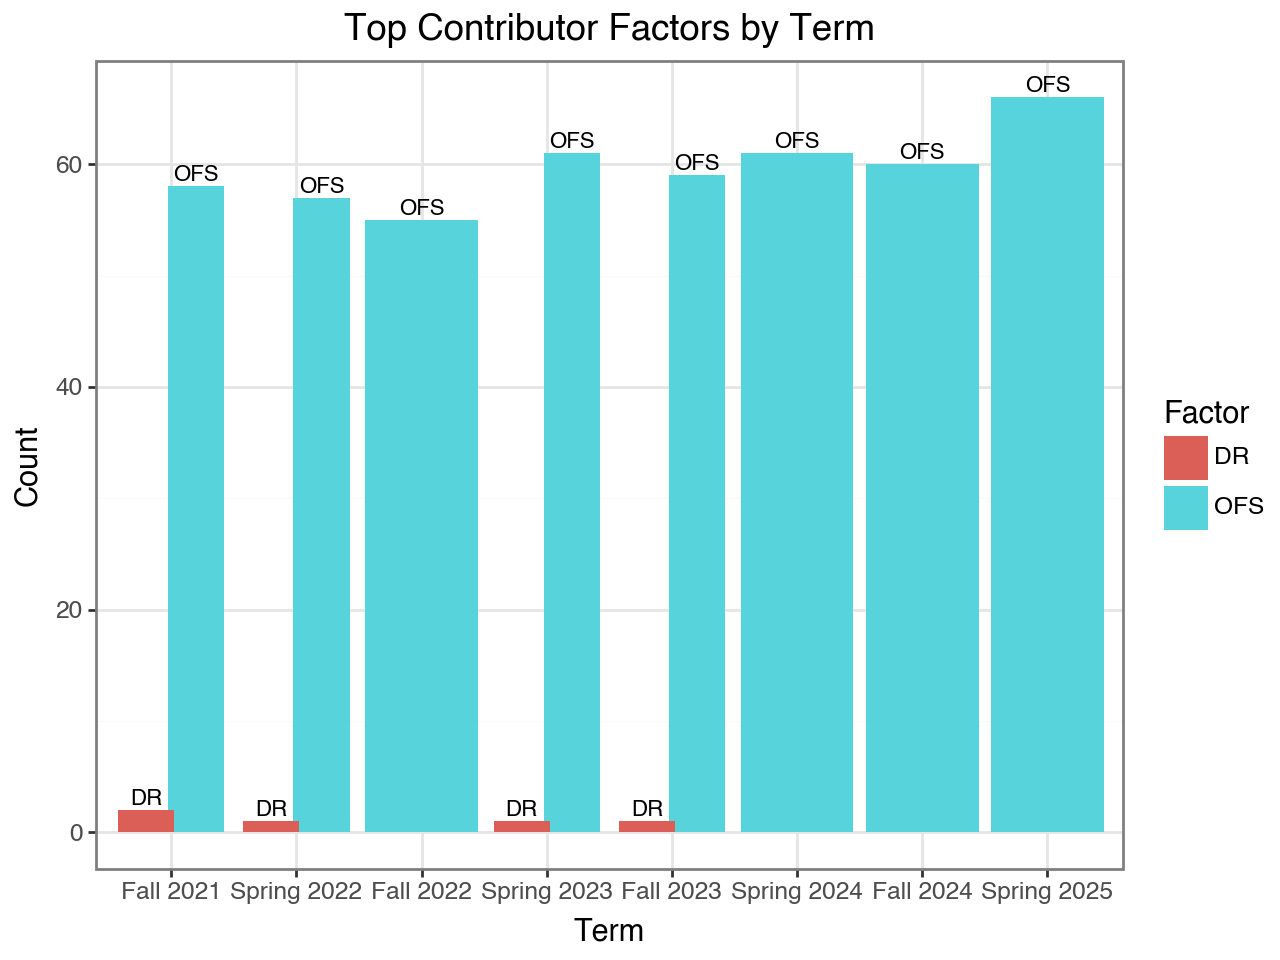

In [316]:
# Graph same code as the Total Graph, except now we're just graphing one Contributor Level at a time
# Graph Top Contributor first, across Terms

cbi_contributor_graph_term_top = (
    ggplot(cbi_contributor_term_counts[cbi_contributor_term_counts["Contributor_Level"] == "Top"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Top Contributor Factors by Term", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

cbi_contributor_graph_term_top


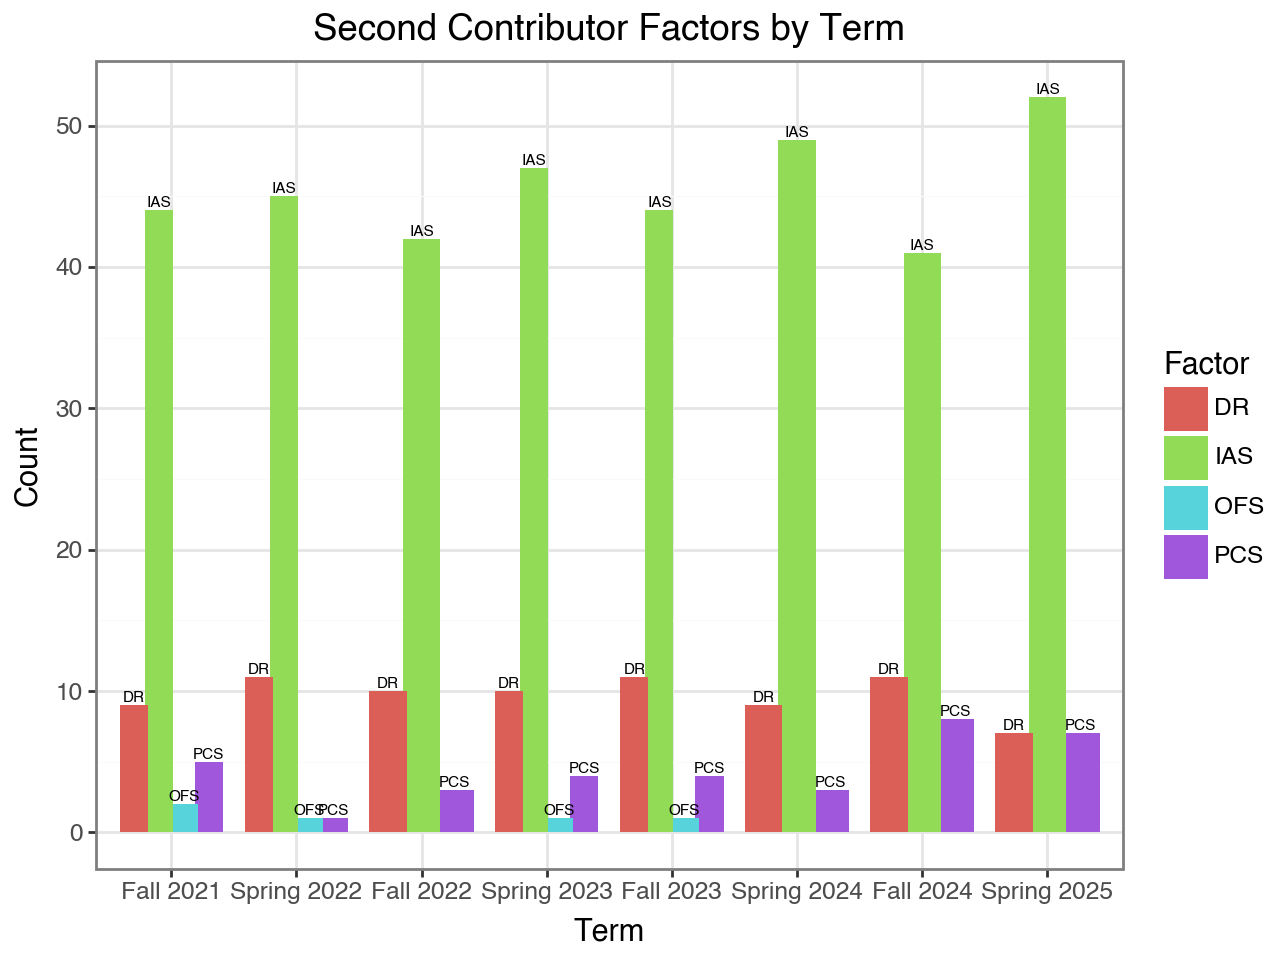

In [317]:
cbi_contributor_graph_term_2nd = (
    ggplot(cbi_contributor_term_counts[cbi_contributor_term_counts["Contributor_Level"] == "Second"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=5.5) +                
    theme_bw() +
    labs(title="Second Contributor Factors by Term", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

cbi_contributor_graph_term_2nd

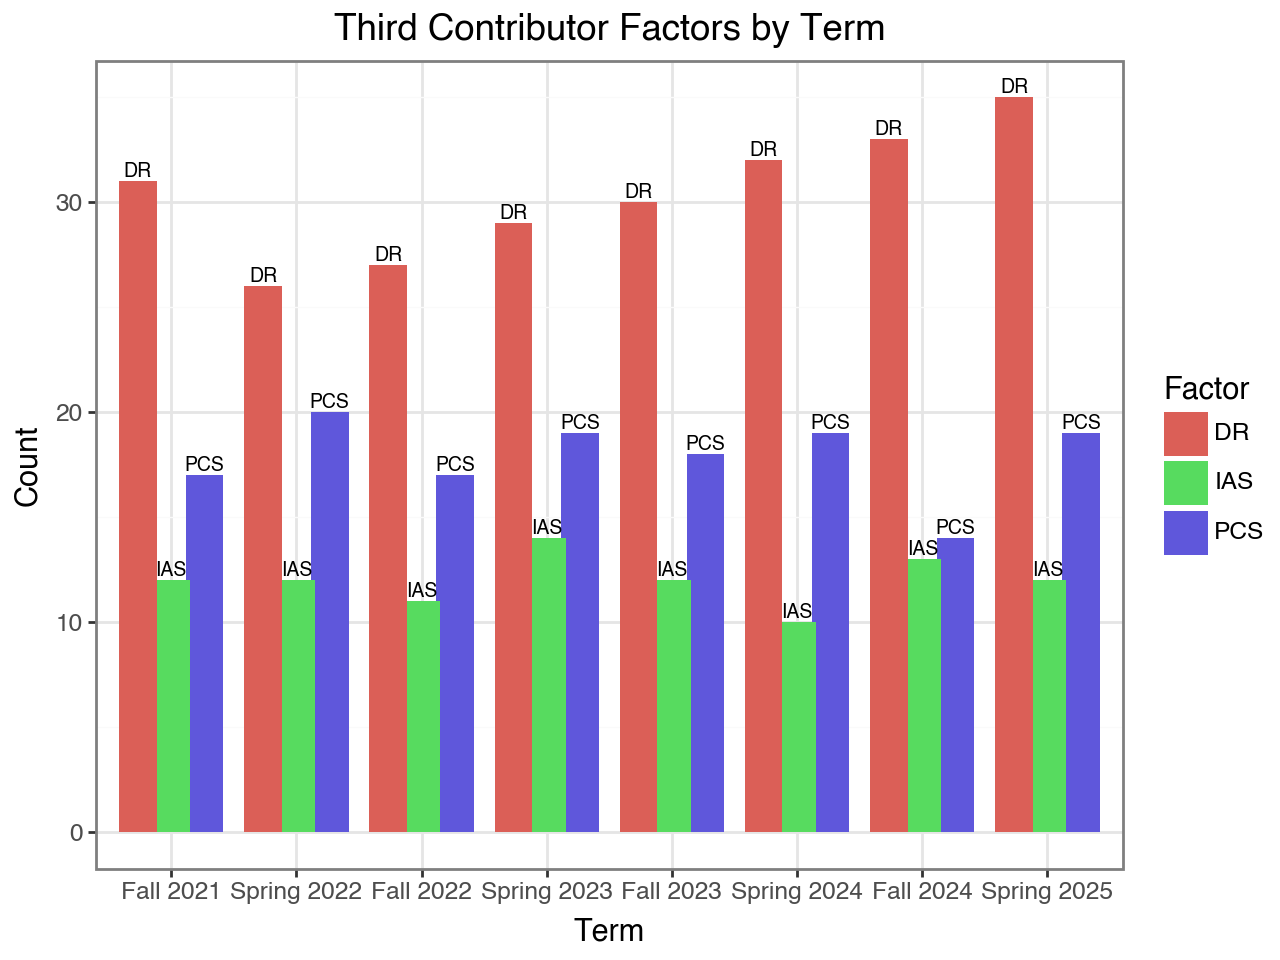

In [318]:
cbi_contributor_graph_term_3rd = (
    ggplot(cbi_contributor_term_counts[cbi_contributor_term_counts["Contributor_Level"] == "Third"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=7) +                
    theme_bw() +
    labs(title="Third Contributor Factors by Term", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

cbi_contributor_graph_term_3rd

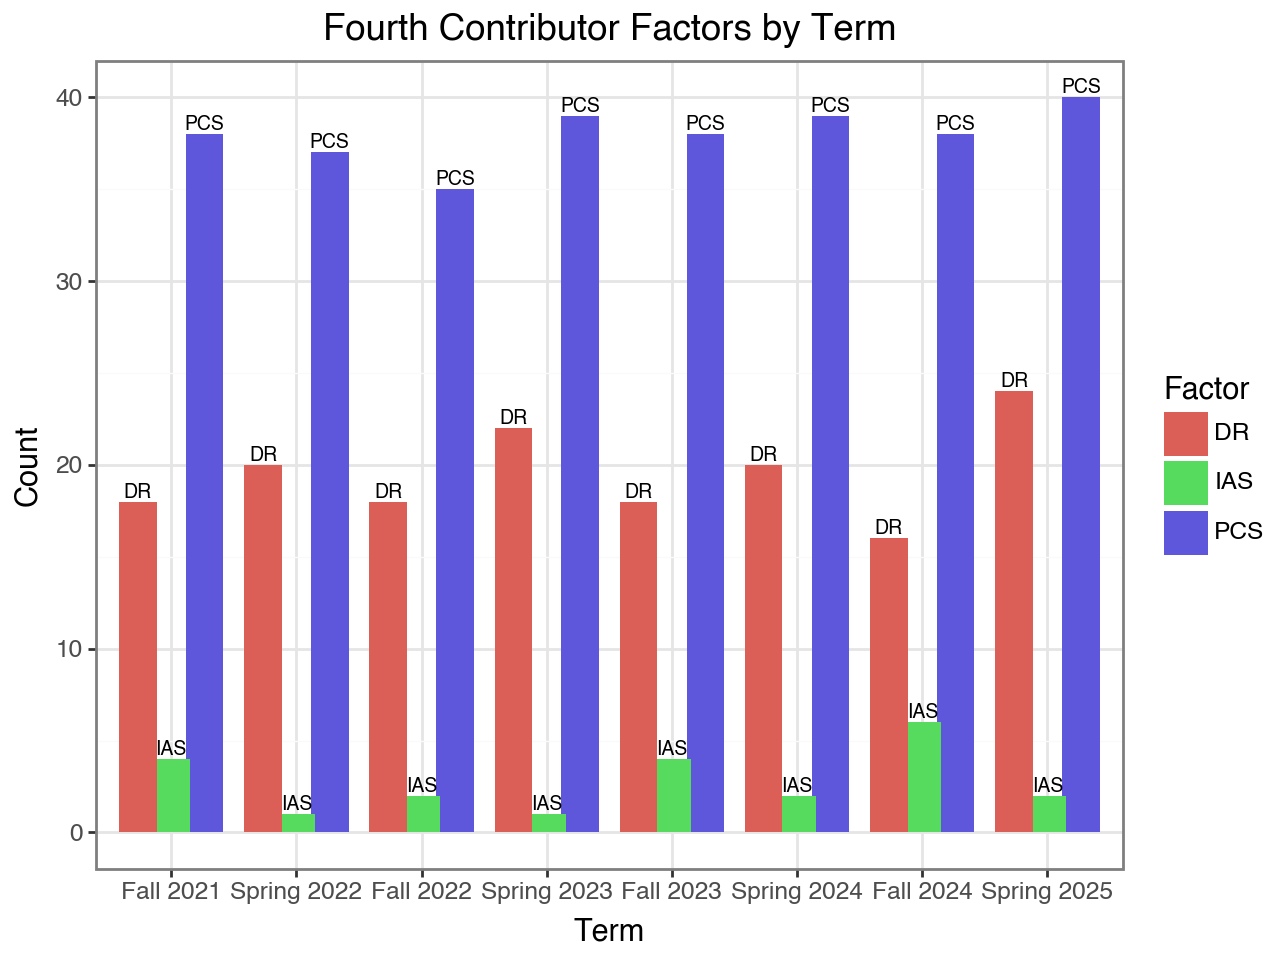

In [319]:
cbi_contributor_graph_term_4th = (
    ggplot(cbi_contributor_term_counts[cbi_contributor_term_counts["Contributor_Level"] == "Fourth"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=7) +                
    theme_bw() +
    labs(title="Fourth Contributor Factors by Term", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

cbi_contributor_graph_term_4th

Statistical Analysis - Term

In [320]:
# Set up Terms & Levels variables for a for-loop 
terms = cbi_contributor_term_counts["Term"].unique()
ranks = ["Top", "Second", "Third", "Fourth"]

# Loop over each Term and Contributor Level
for rank in ranks:
    print(f"\nChi-Square Tests for {rank} Contributors:")

    for term in terms:
        # Filter by Term & Level
        term_rank = cbi_contributor_term_counts[
            (cbi_contributor_term_counts["Term"] == term) &
            (cbi_contributor_term_counts["Contributor_Level"] == rank)]

        if term_rank.empty:
            continue  # skip if no data

        # Observed & expected
        observed = term_rank["Count"].values
        expected = [sum(observed) / len(observed)] * len(observed)

        # Run Chi-square test
        chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
        print(f"  {term}: chi2 = {chi2_stat:.4f}, p = {p_value:.2e}")



Chi-Square Tests for Top Contributors:
  Fall 2021: chi2 = 52.2667, p = 4.85e-13
  Spring 2022: chi2 = 54.0690, p = 1.94e-13
  Fall 2022: chi2 = 0.0000, p = nan
  Spring 2023: chi2 = 58.0645, p = 2.54e-14
  Fall 2023: chi2 = 56.0667, p = 7.01e-14
  Spring 2024: chi2 = 0.0000, p = nan
  Fall 2024: chi2 = 0.0000, p = nan
  Spring 2025: chi2 = 0.0000, p = nan

Chi-Square Tests for Second Contributors:
  Fall 2021: chi2 = 76.4000, p = 1.82e-16
  Spring 2022: chi2 = 90.1379, p = 2.05e-19
  Fall 2022: chi2 = 47.1636, p = 5.74e-11
  Spring 2023: chi2 = 88.0645, p = 5.70e-19
  Fall 2023: chi2 = 78.2667, p = 7.22e-17
  Spring 2024: chi2 = 61.5082, p = 4.40e-14
  Fall 2024: chi2 = 33.3000, p = 5.87e-08
  Spring 2025: chi2 = 61.3636, p = 4.73e-14

Chi-Square Tests for Third Contributors:
  Fall 2021: chi2 = 9.7000, p = 7.83e-03
  Spring 2022: chi2 = 5.1034, p = 7.79e-02
  Fall 2022: chi2 = 7.1273, p = 2.83e-02
  Spring 2023: chi2 = 5.6452, p = 5.95e-02
  Fall 2023: chi2 = 8.4000, p = 1.50e-02
  

Top Contributor note: when chi2 = 0 and p = nan, these are Terms where 100% of the Top Contributors were OFS. With 100% values at OFS, we know that it's statistically significant.

<h2>Factor Analysis on Persistently High / Intermittently High CBI-Score Courses</h2>

<h3>Factor Analysis on Persistently High CBI-Score Courses - By Total</h3>

Persistently High CBI Score, 1+

In [321]:
# New DF for Persistent Courses (>1)
CBI_tot_persistent1 = CBI_tot_factor.copy()
CBI_tot_persistent1 = CBI_tot_persistent1[CBI_tot_persistent1["Course Description"].isin(trend_persistent_high1["Course Description"])]

# Keep Columns "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"
CBI_tot_persistent_narrow1 = CBI_tot_persistent1[[
    "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"]].copy()


In [322]:
# Print counts for each rank
print("Top Contributor Counts for Persistent CBI >1 Courses:")
print(CBI_tot_persistent_narrow1["Top_Contributor"].value_counts())

print("\nSecond Contributor Counts for Persistent CBI >1 Courses:")
print(CBI_tot_persistent_narrow1["Second_Contributor"].value_counts())

print("\nThird Contributor Counts for Persistent CBI >1 Courses:")
print(CBI_tot_persistent_narrow1["Third_Contributor"].value_counts())

print("\nFourth Contributor Counts for Persistent CBI >1 Courses:")
print(CBI_tot_persistent_narrow1["Fourth_Contributor"].value_counts())

Top Contributor Counts for Persistent CBI >1 Courses:
Top_Contributor
OFS    32
Name: count, dtype: int64

Second Contributor Counts for Persistent CBI >1 Courses:
Second_Contributor
IAS    20
PCS    10
DR      2
Name: count, dtype: int64

Third Contributor Counts for Persistent CBI >1 Courses:
Third_Contributor
DR     23
IAS     5
PCS     4
Name: count, dtype: int64

Fourth Contributor Counts for Persistent CBI >1 Courses:
Fourth_Contributor
PCS    18
IAS     7
DR      7
Name: count, dtype: int64


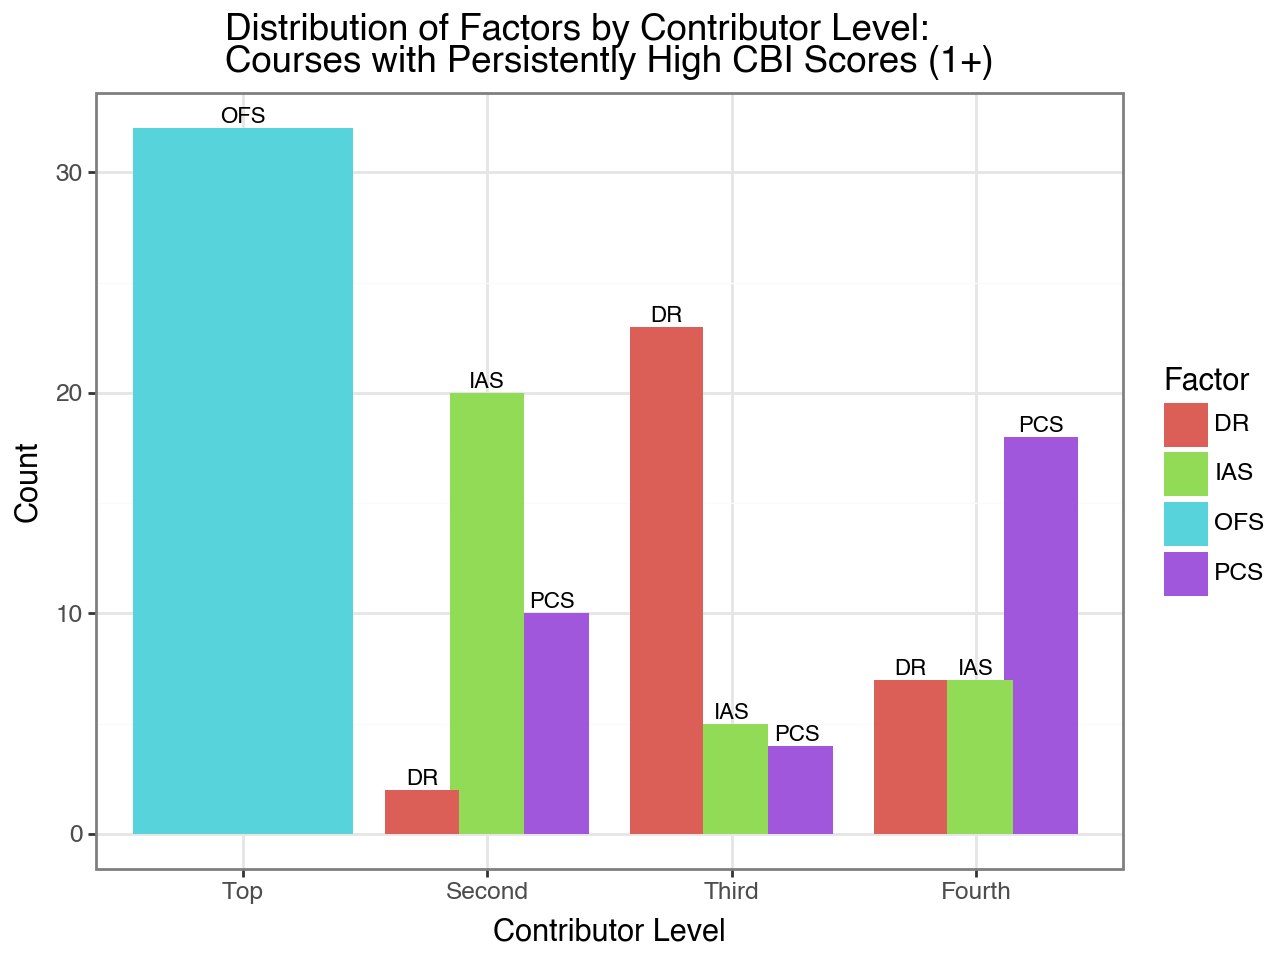

In [323]:
# New DF to Graph, leveraging counts code from above
CBI_tot_persistent1_forgraphing = pd.concat([
    CBI_tot_persistent_narrow1["Top_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Top"),
    CBI_tot_persistent_narrow1["Second_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Second"),
    CBI_tot_persistent_narrow1["Third_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Third"),
    CBI_tot_persistent_narrow1["Fourth_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Fourth"),], ignore_index=True)


# Order levels for the x-axis: "Top", "Second", "Third", "Fourth"
CBI_tot_persistent1_forgraphing["Level"] = pd.Categorical(CBI_tot_persistent1_forgraphing["Level"], 
                                                 categories=["Top", "Second", "Third", "Fourth"], ordered=True)

CBI_tot_persistent_graph_1 = (ggplot(CBI_tot_persistent1_forgraphing, aes(x="Level", y="Count", fill="Factor")) +
                         # Grouped bar chart, use position_dodge
                         geom_bar(stat="identity", position=position_dodge(width=0.8)) +
                         # Add Factor labels on top of bars
                         geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +
                         theme_bw() +
                         labs(title="Distribution of Factors by Contributor Level:\nCourses with Persistently High CBI Scores (1+)", 
                              x="Contributor Level", y="Count") +
                         theme(axis_text_x=element_text(ha='center'), legend_title=element_text(text="Factor")))

CBI_tot_persistent_graph_1

In [324]:
# Test for Statistical Significance
# Only changed the expected_factor_spread variable since I will not be calling these values in the future 

# Expected if equal
expected_factor_spread_highlightedcourses = [32/3, 32/3, 32/3]

# Analyze Second Contributors
observed_second = [20, 10, 2]  # IAS, PCS, DR for problem courses, vs overall Total was DR, IAS, PCS
chi2_stat_second, p_value_second = chisquare(f_obs=observed_second, f_exp=expected_factor_spread_highlightedcourses)

# Analyze Third Contributors
observed_third = [23, 5, 4]  # DR, IAS, PCS, vs overall Total was PCS, IAS, DR
chi2_stat_third, p_value_third = chisquare(f_obs=observed_third, f_exp=expected_factor_spread_highlightedcourses)

# Analyze Fourth Contributors
observed_fourth = [18, 7, 7]  # PCS, IAS, DR, vs overall Total was DR, IAS, PCS
chi2_stat_fourth, p_value_fourth = chisquare(f_obs=observed_fourth, f_exp=expected_factor_spread_highlightedcourses)

print("Statistical Signficance for Persistently High 1+")
print(f"  Second Contributors: chi2 = {chi2_stat_second:.4f}, p = {p_value_second:.4f}")
print(f"  Third Contributors: chi2 = {chi2_stat_third:.4f}, p = {p_value_third:f}")
print(f"  Fourth Contributors: chi2 = {chi2_stat_fourth:.4f}, p = {p_value_fourth:.2e}") #scientific notation, very small

Statistical Signficance for Persistently High 1+
  Second Contributors: chi2 = 15.2500, p = 0.0005
  Third Contributors: chi2 = 21.4375, p = 0.000022
  Fourth Contributors: chi2 = 7.5625, p = 2.28e-02


Factor Analysis x Courses with Persistently High CBI Scores (>1): 4/4 all statistically significant (p < 0.05)
 * Factor Ranking was different for the problem courses than it was for the Overall Courses

Persistently High CBI Score, 1.5+

In [325]:
# New DF for Persistent Courses (>1.5)
CBI_tot_persistent15 = CBI_tot_factor.copy()
CBI_tot_persistent15 = CBI_tot_persistent15[CBI_tot_persistent15["Course Description"].isin(trend_persistent_high15["Course Description"])]

# Keep Columns "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"
CBI_tot_persistent_narrow15 = CBI_tot_persistent15[[
    "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"]].copy()


In [326]:
# Print counts for each rank
print("Top Contributor Counts for Persistent CBI >1.5 Courses:")
print(CBI_tot_persistent_narrow15["Top_Contributor"].value_counts())

print("\nSecond Contributor Counts for Persistent CBI >1.5 Courses:")
print(CBI_tot_persistent_narrow15["Second_Contributor"].value_counts())

print("\nThird Contributor Counts for Persistent CBI >1.5 Courses:")
print(CBI_tot_persistent_narrow15["Third_Contributor"].value_counts())

print("\nFourth Contributor Counts for Persistent CBI >1.5 Courses:")
print(CBI_tot_persistent_narrow15["Fourth_Contributor"].value_counts())

Top Contributor Counts for Persistent CBI >1.5 Courses:
Top_Contributor
OFS    18
Name: count, dtype: int64

Second Contributor Counts for Persistent CBI >1.5 Courses:
Second_Contributor
IAS    11
PCS     5
DR      2
Name: count, dtype: int64

Third Contributor Counts for Persistent CBI >1.5 Courses:
Third_Contributor
DR     11
IAS     4
PCS     3
Name: count, dtype: int64

Fourth Contributor Counts for Persistent CBI >1.5 Courses:
Fourth_Contributor
PCS    10
DR      5
IAS     3
Name: count, dtype: int64


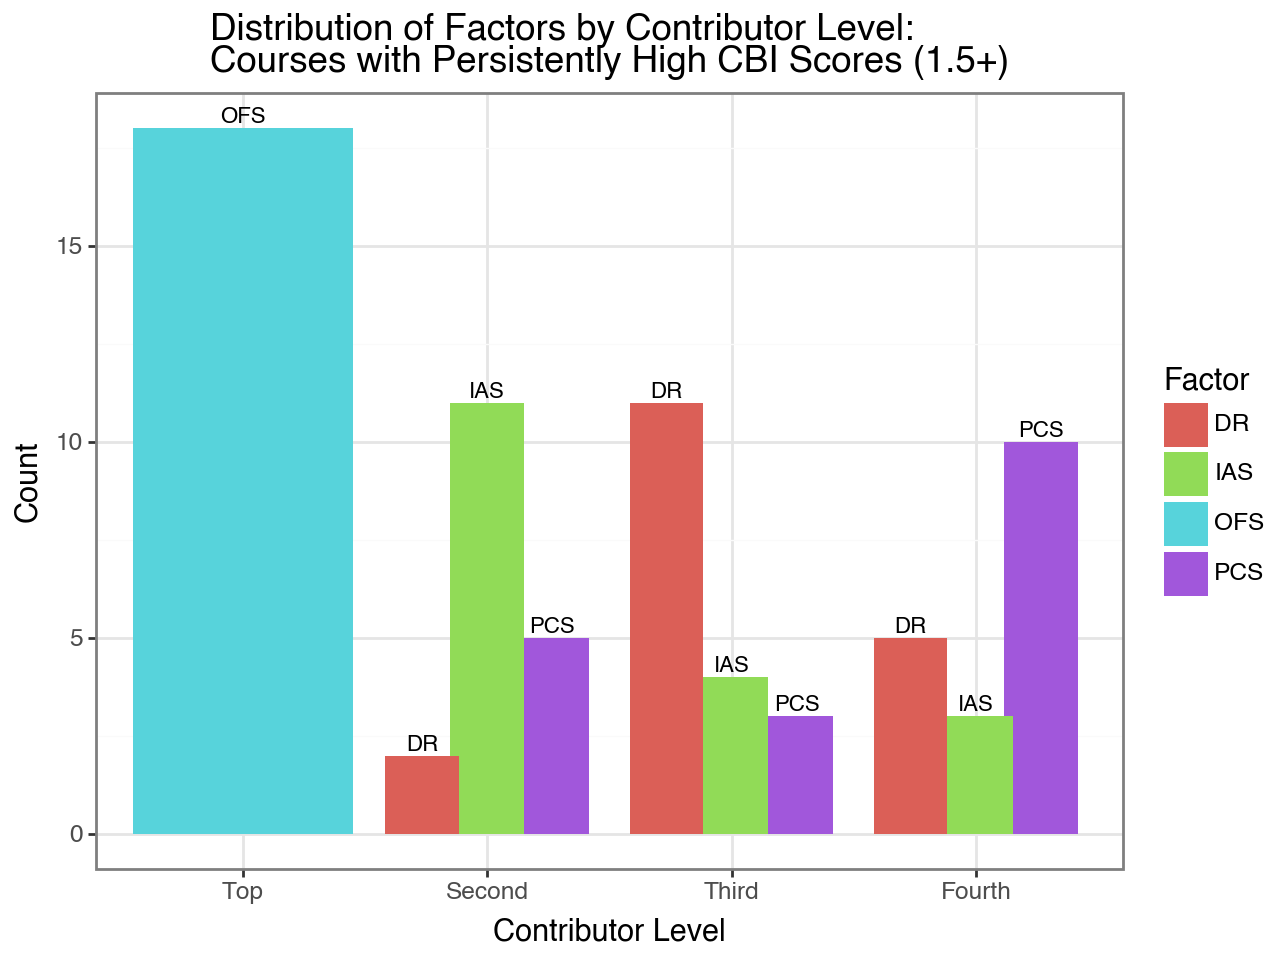

In [327]:
# New DF to Graph, leveraging counts code from above
CBI_tot_persistent15_forgraphing = pd.concat([
    CBI_tot_persistent_narrow15["Top_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Top"),
    CBI_tot_persistent_narrow15["Second_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Second"),
    CBI_tot_persistent_narrow15["Third_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Third"),
    CBI_tot_persistent_narrow15["Fourth_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Fourth"),], ignore_index=True)


# Order levels for the x-axis: "Top", "Second", "Third", "Fourth"
CBI_tot_persistent15_forgraphing["Level"] = pd.Categorical(CBI_tot_persistent15_forgraphing["Level"], 
                                                 categories=["Top", "Second", "Third", "Fourth"], ordered=True)

CBI_tot_persistent_graph_15 = (ggplot(CBI_tot_persistent15_forgraphing, aes(x="Level", y="Count", fill="Factor")) +
                         # Grouped bar chart, use position_dodge
                         geom_bar(stat="identity", position=position_dodge(width=0.8)) +
                         # Add Factor labels on top of bars
                         geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +
                         theme_bw() +
                         labs(title="Distribution of Factors by Contributor Level:\nCourses with Persistently High CBI Scores (1.5+)", 
                              x="Contributor Level", y="Count") +
                         theme(axis_text_x=element_text(ha='center'), legend_title=element_text(text="Factor")))

CBI_tot_persistent_graph_15


In [328]:
# Test for Statistical Significance
# Only changed the expected_factor_spread variable since I will not be calling these values in the future 

# Expected if equal
expected_factor_spread_highlightedcourses = [6, 6, 6]

# Analyze Second Contributors
observed_second = [11, 5, 2]  # IAS, PCS, DR for problem courses, vs overall Total was DR, IAS, PCS, same as 1+ CBI courses though
chi2_stat_second, p_value_second = chisquare(f_obs=observed_second, f_exp=expected_factor_spread_highlightedcourses)

# Analyze Third Contributors
observed_third = [11, 4, 3]  # DR, IAS, PCS, vs overall Total was PCS, IAS, DR, same as 1+ CBI courses though
chi2_stat_third, p_value_third = chisquare(f_obs=observed_third, f_exp=expected_factor_spread_highlightedcourses)

# Analyze Fourth Contributors
observed_fourth = [10, 5, 3]  # PCS, DR, IAS, vs overall Total was DR, IAS, PCS
chi2_stat_fourth, p_value_fourth = chisquare(f_obs=observed_fourth, f_exp=expected_factor_spread_highlightedcourses)

print("Statistical Signficance for Persistently High 1.5+")
print(f"  Second Contributors: chi2 = {chi2_stat_second:.4f}, p = {p_value_second:.4f}")
print(f"  Third Contributors: chi2 = {chi2_stat_third:.4f}, p = {p_value_third:f}")
print(f"  Fourth Contributors: chi2 = {chi2_stat_fourth:.4f}, p = {p_value_fourth:.2e}") #scientific notation, very small

Statistical Signficance for Persistently High 1.5+
  Second Contributors: chi2 = 7.0000, p = 0.0302
  Third Contributors: chi2 = 6.3333, p = 0.042144
  Fourth Contributors: chi2 = 4.3333, p = 1.15e-01


Factor Analysis x Courses with Persistently High CBI Scores (>1.5): 4/4 all statistically significant (p < 0.05)
 * Factor Ranking was different for the problem courses than it was for the Overall Courses
 * Factors 1-3 had the same order as the Persistent 1+ courses, Factor 4 deviated

<h3>Factor Analysis on Intermittently High CBI-Score Courses - By Total</h3>

Intermittently High CBI 1+

In [329]:
# New DF for Persistent Courses (>1)
CBI_tot_intermittent1 = CBI_tot_factor.copy()
CBI_tot_intermittent1 = CBI_tot_intermittent1[CBI_tot_intermittent1["Course Description"].isin(trend_intermittent2_high1["Course Description"])]


# Keep Columns "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"
CBI_tot_intermittent1_narrow = CBI_tot_intermittent1[[
    "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"]].copy()
CBI_tot_intermittent1_narrow

# Print counts for each rank
print("Top Contributor Counts for Intermittent CBI >1 Courses:")
print(CBI_tot_intermittent1_narrow["Top_Contributor"].value_counts())

print("\nSecond Contributor Counts for Intermittent CBI >1 Courses:")
print(CBI_tot_intermittent1_narrow["Second_Contributor"].value_counts())

print("\nThird Contributor Counts for Intermittent CBI >1 Courses:")
print(CBI_tot_intermittent1_narrow["Third_Contributor"].value_counts())

print("\nFourth Contributor Counts for Intermittent CBI >1 Courses:")
print(CBI_tot_intermittent1_narrow["Fourth_Contributor"].value_counts())

Top Contributor Counts for Intermittent CBI >1 Courses:
Top_Contributor
OFS    12
Name: count, dtype: int64

Second Contributor Counts for Intermittent CBI >1 Courses:
Second_Contributor
IAS    10
PCS     2
Name: count, dtype: int64

Third Contributor Counts for Intermittent CBI >1 Courses:
Third_Contributor
DR     8
PCS    3
IAS    1
Name: count, dtype: int64

Fourth Contributor Counts for Intermittent CBI >1 Courses:
Fourth_Contributor
PCS    7
DR     4
IAS    1
Name: count, dtype: int64


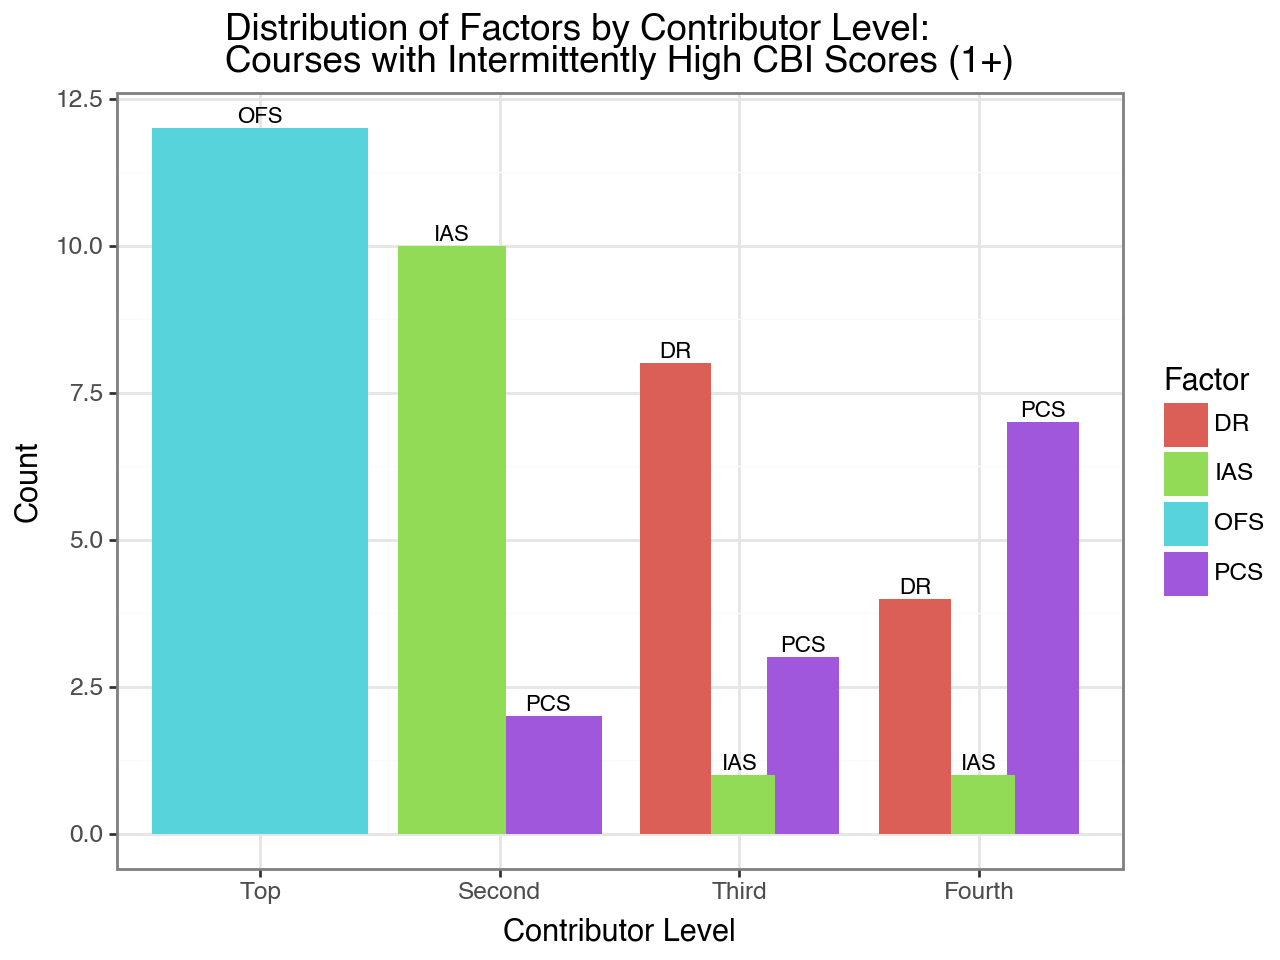

In [330]:
# New DF to Graph, leveraging counts code from above
CBI_tot_intermittent1_forgraphing = pd.concat([
    CBI_tot_intermittent1_narrow["Top_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Top"),
    CBI_tot_intermittent1_narrow["Second_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Second"),
    CBI_tot_intermittent1_narrow["Third_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Third"),
    CBI_tot_intermittent1_narrow["Fourth_Contributor"].value_counts().rename_axis('Factor').reset_index(name='Count').assign(Level="Fourth"),], ignore_index=True)


# Order levels for the x-axis: "Top", "Second", "Third", "Fourth"
CBI_tot_intermittent1_forgraphing["Level"] = pd.Categorical(CBI_tot_intermittent1_forgraphing["Level"], 
                                                 categories=["Top", "Second", "Third", "Fourth"], ordered=True)

CBI_tot_intermittent_graph_1 = (ggplot(CBI_tot_intermittent1_forgraphing, aes(x="Level", y="Count", fill="Factor")) +
                         # Grouped bar chart, use position_dodge
                         geom_bar(stat="identity", position=position_dodge(width=0.8)) +
                         # Add Factor labels on top of bars
                         geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +
                         theme_bw() +
                         labs(title="Distribution of Factors by Contributor Level:\nCourses with Intermittently High CBI Scores (1+)", 
                              x="Contributor Level", y="Count") +
                         theme(axis_text_x=element_text(ha='center'), legend_title=element_text(text="Factor")))

CBI_tot_intermittent_graph_1

In [331]:
# Test for Statistical Significance
# Only changed the expected_factor_spread variable since I will not be calling these values in the future 

# Expected if equal
expected_factor_spread_highlightedcourses = [4, 4, 4]

# Analyze Second Contributors
observed_second = [10, 2, 0]  # IAS, PCS, N/A for problem courses, vs overall Total was DR, IAS, PCS
chi2_stat_second, p_value_second = chisquare(f_obs=observed_second, f_exp=expected_factor_spread_highlightedcourses)

# Analyze Third Contributors
observed_third = [8, 3, 1]  # DR, PCS, IAS, vs overall Total was PCS, IAS, DR
chi2_stat_third, p_value_third = chisquare(f_obs=observed_third, f_exp=expected_factor_spread_highlightedcourses)

# Analyze Fourth Contributors
observed_fourth = [7, 4, 1]  # PCS, DR, IAS, vs overall Total was DR, IAS, PCS
chi2_stat_fourth, p_value_fourth = chisquare(f_obs=observed_fourth, f_exp=expected_factor_spread_highlightedcourses)

print("Statistical Signficance for Intermittently High 1+")
print(f"  Second Contributors: chi2 = {chi2_stat_second:.4f}, p = {p_value_second:.4f}")
print(f"  Third Contributors: chi2 = {chi2_stat_third:.4f}, p = {p_value_third:f}")
print(f"  Fourth Contributors: chi2 = {chi2_stat_fourth:.4f}, p = {p_value_fourth:.2e}") #scientific notation, very small

Statistical Signficance for Intermittently High 1+
  Second Contributors: chi2 = 14.0000, p = 0.0009
  Third Contributors: chi2 = 6.5000, p = 0.038774
  Fourth Contributors: chi2 = 4.5000, p = 1.05e-01


<h3>Factor Analysis on Persistently High CBI-Score Courses - By Term</h3>

Persistently High CBI Score, 1+

In [332]:
# Factor x Term for Persistently High CBI Scores 1+
CBI_term_persistent1 = CBI_term_factor[CBI_term_factor["Course Description"].isin(
    trend_persistent_high1["Course Description"])].copy()

# Lock Terms in order the order they're in (by academic year)
CBI_term_persistent1["Term"] = pd.Categorical(CBI_term_persistent1["Term"], 
                                              categories=CBI_term["Term"].unique(), ordered=True)
# Sort by Term then Course Description
CBI_term_persistent1 = CBI_term_persistent1.sort_values(["Term", "Course Description"])

# Keep Columns "Term", "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"
CBI_term_persistent1_narrow = CBI_term_persistent1[[
    "Term", "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"]].copy()


In [333]:
# Variables for Factor Counts for Top, Second, Third, Fourth Contributors by Term
top_contributor_countsterm_persistent1 = (CBI_term_persistent1_narrow.groupby(["Term", "Top_Contributor"], observed=True)
    .size().reset_index(name="Count"))

second_contributor_countsterm_persistent1 = (CBI_term_persistent1_narrow.groupby(["Term", "Second_Contributor"], observed=True)
    .size().reset_index(name="Count"))

third_contributor_countsterm_persistent1 = (CBI_term_persistent1_narrow.groupby(["Term", "Third_Contributor"], observed=True)
    .size().reset_index(name="Count"))

fourth_contributor_countsterm_persistent1 = (CBI_term_persistent1_narrow.groupby(["Term", "Fourth_Contributor"], observed=True)
    .size().reset_index(name="Count"))

# Print the factor counts for Top, Second, Third, Fourth Contributors by Term
print("Top Contributor Counts by Term for Persistent CBI >1 Courses:")
print(top_contributor_countsterm_persistent1)

print("\nSecond Contributor Counts by Term for Persistent CBI >1 Courses:")
print(second_contributor_countsterm_persistent1)

print("\nThird Contributor Counts by Term for Persistent CBI >1 Courses:")
print(third_contributor_countsterm_persistent1)

print("\nFourth Contributor Counts by Term for Persistent CBI >1 Courses:")
print(fourth_contributor_countsterm_persistent1)

Top Contributor Counts by Term for Persistent CBI >1 Courses:
          Term Top_Contributor  Count
0    Fall 2021             OFS     15
1  Spring 2022             OFS     12
2    Fall 2022             OFS      9
3  Spring 2023             OFS     15
4    Fall 2023             OFS     14
5  Spring 2024             OFS     15
6    Fall 2024             OFS     16
7  Spring 2025             OFS     19

Second Contributor Counts by Term for Persistent CBI >1 Courses:
           Term Second_Contributor  Count
0     Fall 2021                IAS     14
1     Fall 2021                PCS      1
2   Spring 2022                IAS     12
3     Fall 2022                 DR      1
4     Fall 2022                IAS      8
5   Spring 2023                IAS     14
6   Spring 2023                PCS      1
7     Fall 2023                IAS     14
8   Spring 2024                IAS     15
9     Fall 2024                 DR      1
10    Fall 2024                IAS     15
11  Spring 2025           

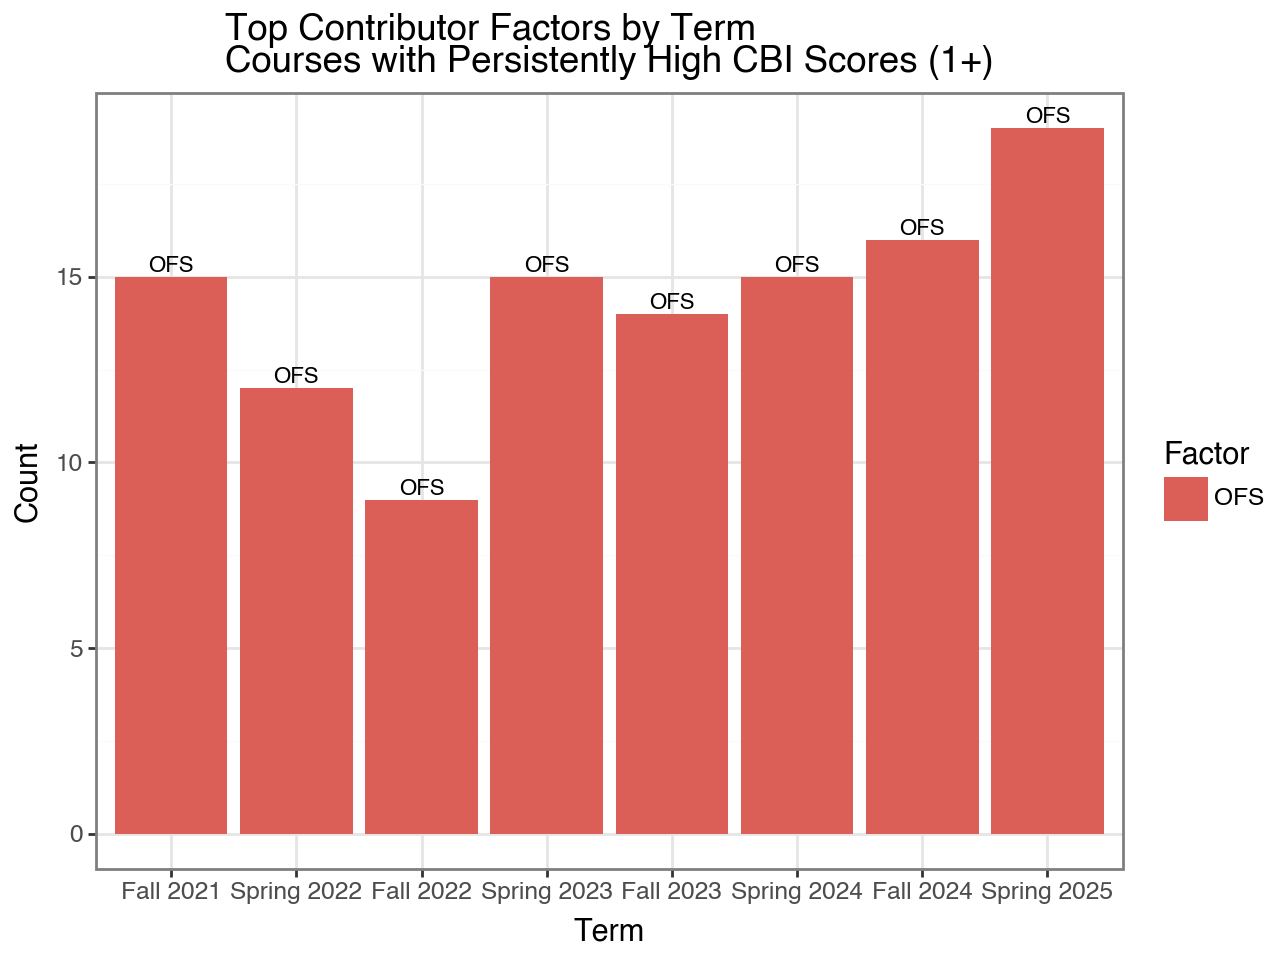

In [334]:
# New DF to store Factor Counts by Top/2nd/3rd/4th Contributor
# First - Add a column to each DF above (e.g. "Top" to top_contributor_counts_by_term) to identify in the final DF
top_contributor_countsterm_persistent1["Contributor_Level"] = "Top"
second_contributor_countsterm_persistent1["Contributor_Level"] = "Second"
third_contributor_countsterm_persistent1["Contributor_Level"] = "Third"
fourth_contributor_countsterm_persistent1["Contributor_Level"] = "Fourth"

# Concatenate the DFs, rename the old top/second/etc columns to "Factor"
cbi_contributor_countsterm_persistent1 = pd.concat([
    top_contributor_countsterm_persistent1.rename(columns={"Top_Contributor": "Factor"}),
    second_contributor_countsterm_persistent1.rename(columns={"Second_Contributor": "Factor"}),
    third_contributor_countsterm_persistent1.rename(columns={"Third_Contributor": "Factor"}),
    fourth_contributor_countsterm_persistent1.rename(columns={"Fourth_Contributor": "Factor"})], ignore_index=True)

# Graph same code as the Total Graph, except now we're just graphing one Contributor Level at a time
# Graph Top Contributor first, across Terms

graph_top_contributor_countsterm_persistent1 = (
    ggplot(cbi_contributor_countsterm_persistent1[cbi_contributor_countsterm_persistent1["Contributor_Level"] == "Top"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Top Contributor Factors by Term\nCourses with Persistently High CBI Scores (1+)", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

graph_top_contributor_countsterm_persistent1

The full Factor x Term graph had OFS & DR
--> for the persistently high CBI courses, they're 100% driven by OFS

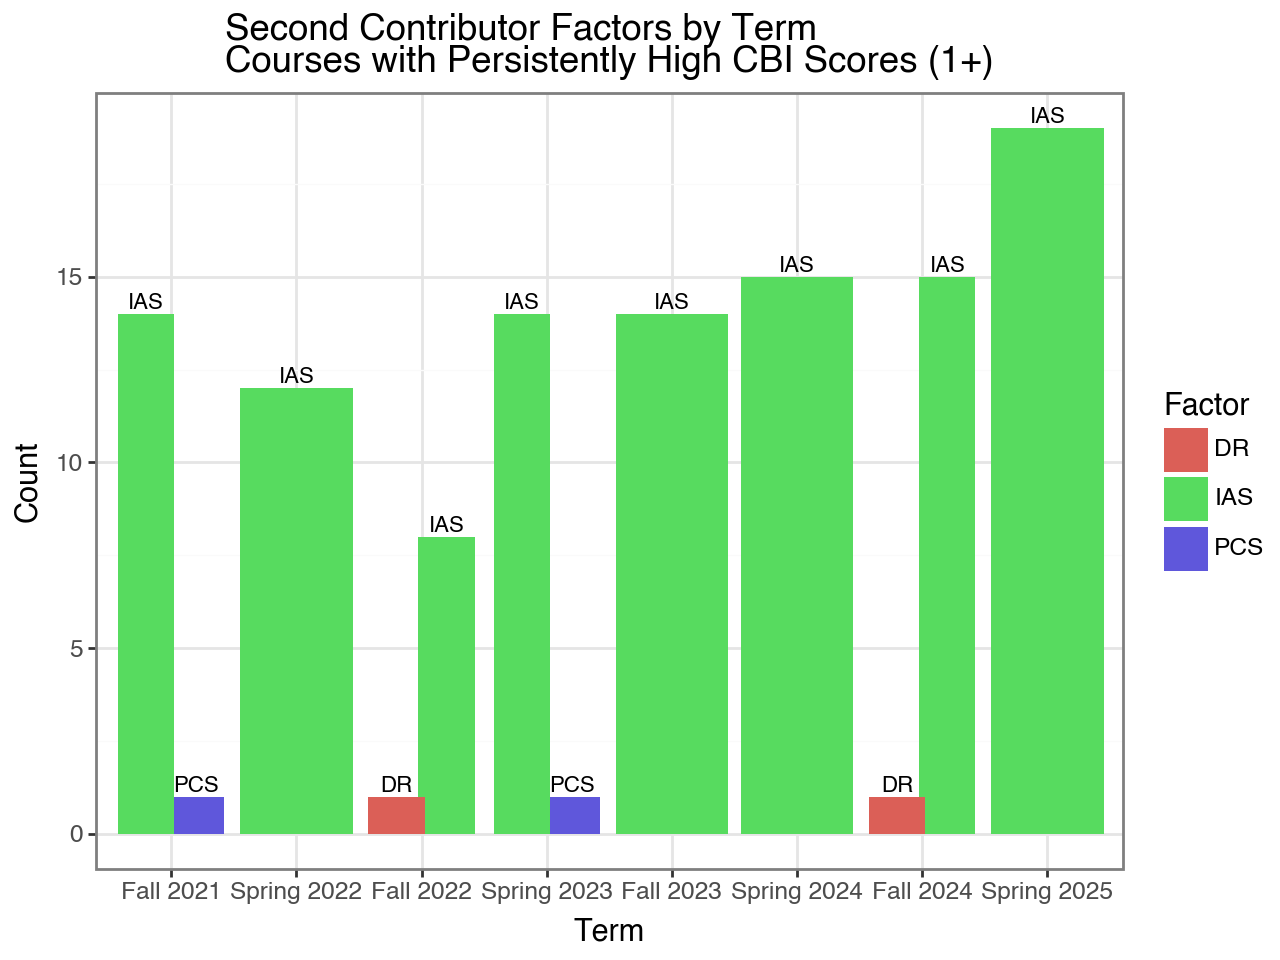

In [335]:
graph_2nd_contributor_countsterm_persistent1 = (
    ggplot(cbi_contributor_countsterm_persistent1[cbi_contributor_countsterm_persistent1["Contributor_Level"] == "Second"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Second Contributor Factors by Term\nCourses with Persistently High CBI Scores (1+)", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

graph_2nd_contributor_countsterm_persistent1

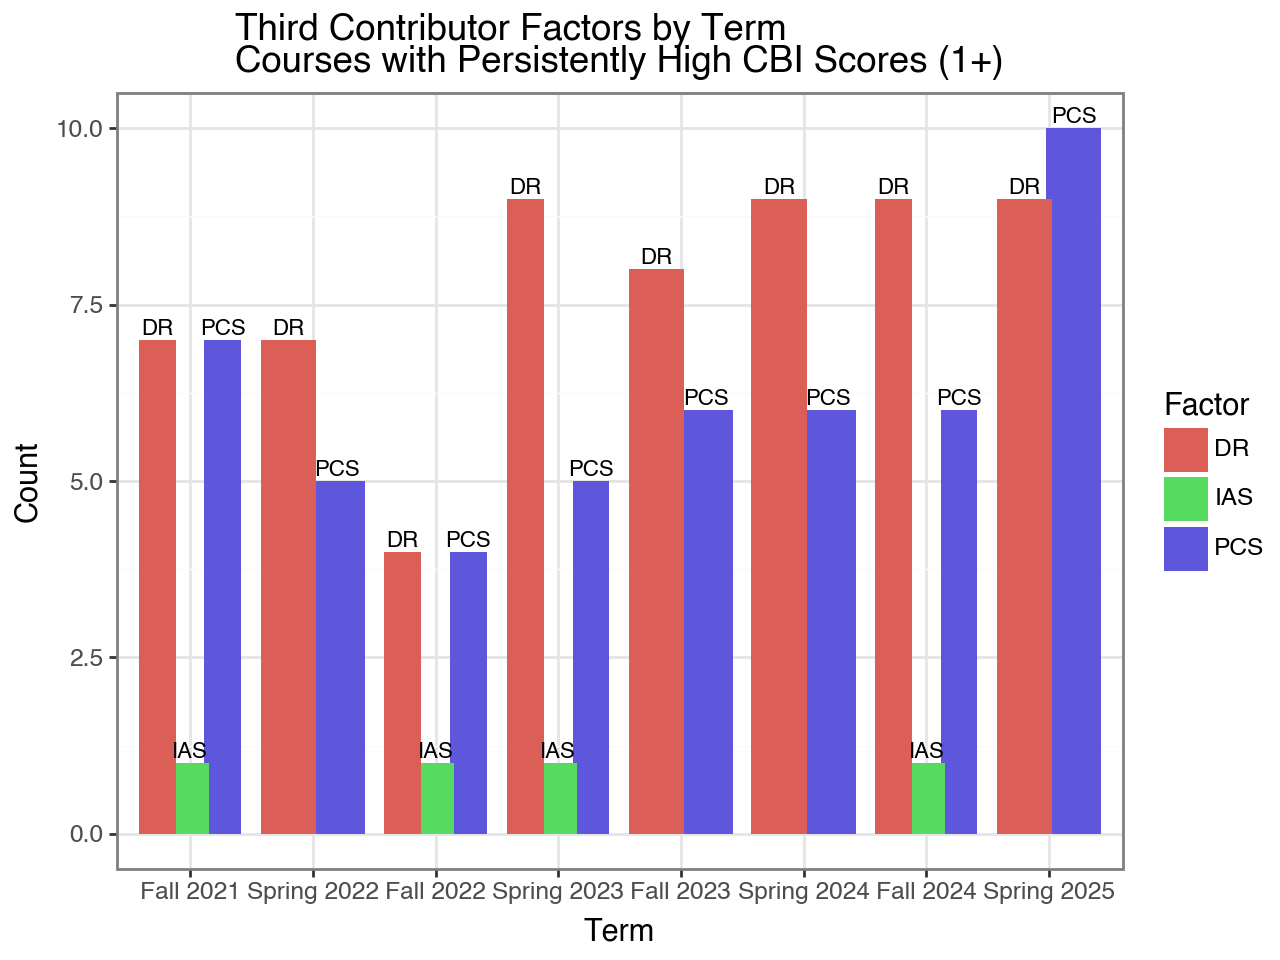

In [336]:
graph_3rd_contributor_countsterm_persistent1 = (
    ggplot(cbi_contributor_countsterm_persistent1[cbi_contributor_countsterm_persistent1["Contributor_Level"] == "Third"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Third Contributor Factors by Term\nCourses with Persistently High CBI Scores (1+)", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

graph_3rd_contributor_countsterm_persistent1

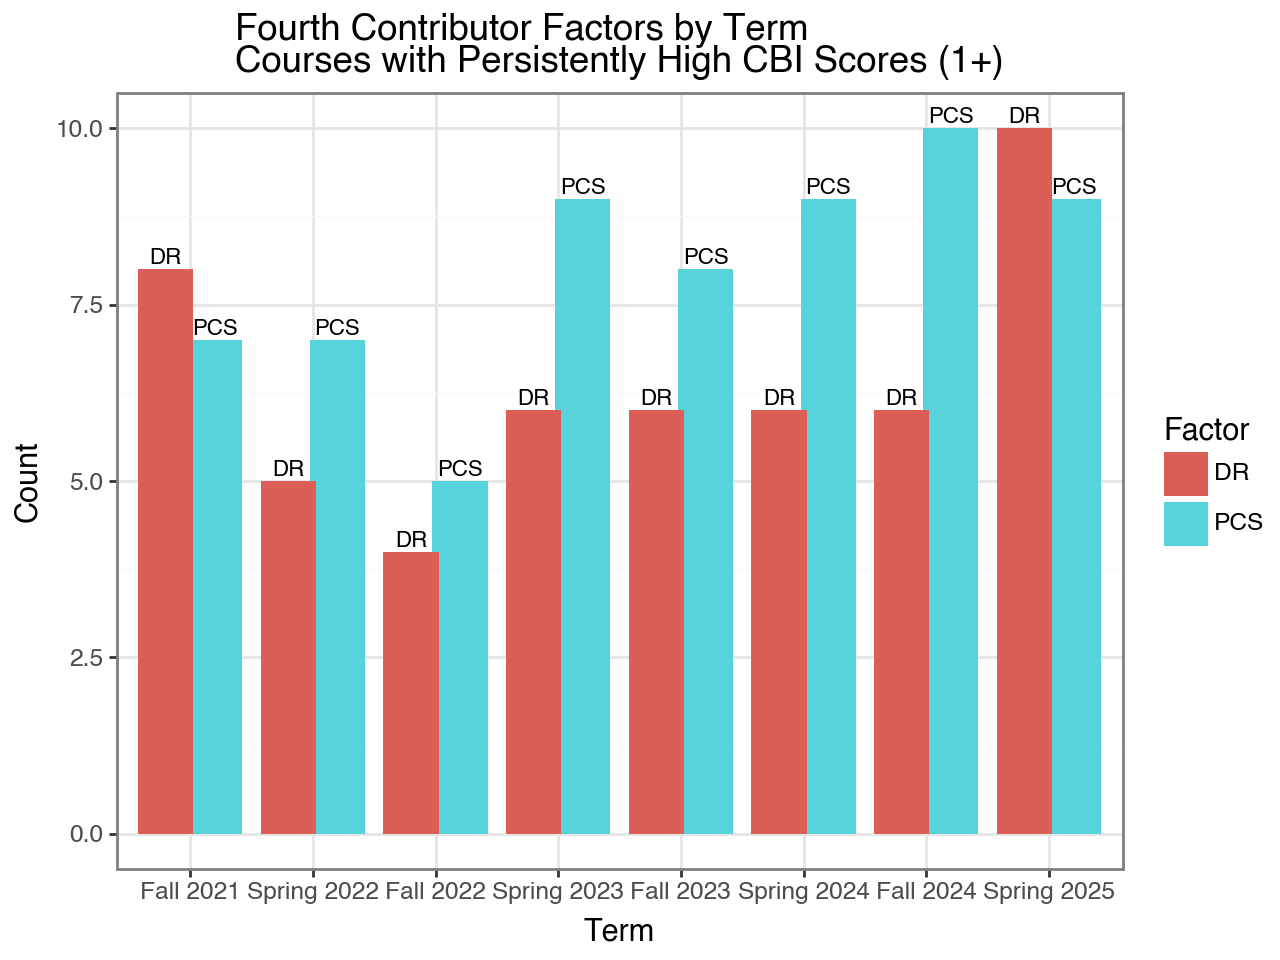

In [337]:
graph_4th_contributor_countsterm_persistent1 = (
    ggplot(cbi_contributor_countsterm_persistent1[cbi_contributor_countsterm_persistent1["Contributor_Level"] == "Fourth"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Fourth Contributor Factors by Term\nCourses with Persistently High CBI Scores (1+)", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

graph_4th_contributor_countsterm_persistent1

Statistical Analysis for Factor x Term x Persistent 1+ 

In [338]:
# Same for-loop as above on new DF

# Set up Terms & Levels variables for a for-loop 
terms = cbi_contributor_countsterm_persistent1["Term"].unique()
ranks = ["Top", "Second", "Third", "Fourth"]

# Loop over each Term and Contributor Level
for rank in ranks:
    print(f"\nChi-Square Tests for {rank} Contributors:")

    for term in terms:
        # Filter by Term & Level
        term_rank = cbi_contributor_countsterm_persistent1[
            (cbi_contributor_countsterm_persistent1["Term"] == term) &
            (cbi_contributor_countsterm_persistent1["Contributor_Level"] == rank)]

        if term_rank.empty:
            continue  # skip if no data

        # Observed & expected
        observed = term_rank["Count"].values
        expected = [sum(observed) / len(observed)] * len(observed)

        # Run Chi-square test
        chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
        print(f"  {term}: chi2 = {chi2_stat:.4f}, p = {p_value:.2e}")


Chi-Square Tests for Top Contributors:
  Fall 2021: chi2 = 0.0000, p = nan
  Spring 2022: chi2 = 0.0000, p = nan
  Fall 2022: chi2 = 0.0000, p = nan
  Spring 2023: chi2 = 0.0000, p = nan
  Fall 2023: chi2 = 0.0000, p = nan
  Spring 2024: chi2 = 0.0000, p = nan
  Fall 2024: chi2 = 0.0000, p = nan
  Spring 2025: chi2 = 0.0000, p = nan

Chi-Square Tests for Second Contributors:
  Fall 2021: chi2 = 11.2667, p = 7.89e-04
  Spring 2022: chi2 = 0.0000, p = nan
  Fall 2022: chi2 = 5.4444, p = 1.96e-02
  Spring 2023: chi2 = 11.2667, p = 7.89e-04
  Fall 2023: chi2 = 0.0000, p = nan
  Spring 2024: chi2 = 0.0000, p = nan
  Fall 2024: chi2 = 12.2500, p = 4.65e-04
  Spring 2025: chi2 = 0.0000, p = nan

Chi-Square Tests for Third Contributors:
  Fall 2021: chi2 = 4.8000, p = 9.07e-02
  Spring 2022: chi2 = 0.3333, p = 5.64e-01
  Fall 2022: chi2 = 2.0000, p = 3.68e-01
  Spring 2023: chi2 = 6.4000, p = 4.08e-02
  Fall 2023: chi2 = 0.2857, p = 5.93e-01
  Spring 2024: chi2 = 0.6000, p = 4.39e-01
  Fall 2

Where chi^2 = 0 and p = NaN, these were the 100% values -> we know they're statistically significant

<h3>Factor Analysis on Intermittently High CBI-Score Courses - By Term</h3>

Intermittently High 1+

In [339]:
# Factor x Term for Persistently High CBI Scores 1+
CBI_term_intermittent1 = CBI_term_factor[CBI_term_factor["Course Description"].isin(
    trend_intermittent2_high1["Course Description"])].copy()

# Lock Terms in order the order they're in (by academic year)
CBI_term_intermittent1["Term"] = pd.Categorical(CBI_term_intermittent1["Term"], 
                                              categories=CBI_term["Term"].unique(), ordered=True)
# Sort by Term then Course Description
CBI_term_intermittent1 = CBI_term_intermittent1.sort_values(["Term", "Course Description"])

# Keep Columns "Term", "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"
CBI_term_intermittent1_narrow = CBI_term_intermittent1[[
    "Term", "Course Description", "CBI", "Top_Contributor", "Second_Contributor", "Third_Contributor", "Fourth_Contributor"]].copy()

In [340]:
# Variables for Factor Counts for Top, Second, Third, Fourth Contributors by Term
top_contributor_countsterm_intermit1 = (CBI_term_intermittent1_narrow.groupby(["Term", "Top_Contributor"], observed=True)
    .size().reset_index(name="Count"))

second_contributor_countsterm_intermit1 = (CBI_term_intermittent1_narrow.groupby(["Term", "Second_Contributor"], observed=True)
    .size().reset_index(name="Count"))

third_contributor_countsterm_intermit1 = (CBI_term_intermittent1_narrow.groupby(["Term", "Third_Contributor"], observed=True)
    .size().reset_index(name="Count"))

fourth_contributor_countsterm_intermit1 = (CBI_term_intermittent1_narrow.groupby(["Term", "Fourth_Contributor"], observed=True)
    .size().reset_index(name="Count"))

# Print the factor counts for Top, Second, Third, Fourth Contributors by Term
print("Top Contributor Counts by Term for Intermittent CBI >1 Courses:")
print(top_contributor_countsterm_intermit1)

print("\nSecond Contributor Counts by Term for Intermittent CBI >1 Courses:")
print(second_contributor_countsterm_intermit1)

print("\nThird Contributor Counts by Term for Intermittent CBI >1 Courses:")
print(third_contributor_countsterm_intermit1)

print("\nFourth Contributor Counts by Term for Intermittent CBI >1 Courses:")
print(fourth_contributor_countsterm_intermit1)

Top Contributor Counts by Term for Intermittent CBI >1 Courses:
          Term Top_Contributor  Count
0    Fall 2021             OFS      6
1  Spring 2022             OFS      3
2  Spring 2023             OFS      2
3  Spring 2024             OFS      4
4  Spring 2025             OFS      6

Second Contributor Counts by Term for Intermittent CBI >1 Courses:
          Term Second_Contributor  Count
0    Fall 2021                IAS      5
1    Fall 2021                PCS      1
2  Spring 2022                IAS      3
3  Spring 2023                IAS      2
4  Spring 2024                IAS      4
5  Spring 2025                IAS      6

Third Contributor Counts by Term for Intermittent CBI >1 Courses:
           Term Third_Contributor  Count
0     Fall 2021                DR      4
1     Fall 2021               IAS      1
2     Fall 2021               PCS      1
3   Spring 2022                DR      2
4   Spring 2022               PCS      1
5   Spring 2023                DR      1

For the Intermittently High (1+) courses, 100% of factor 1 is OFS, 5/6 of Factor 1 is PCS

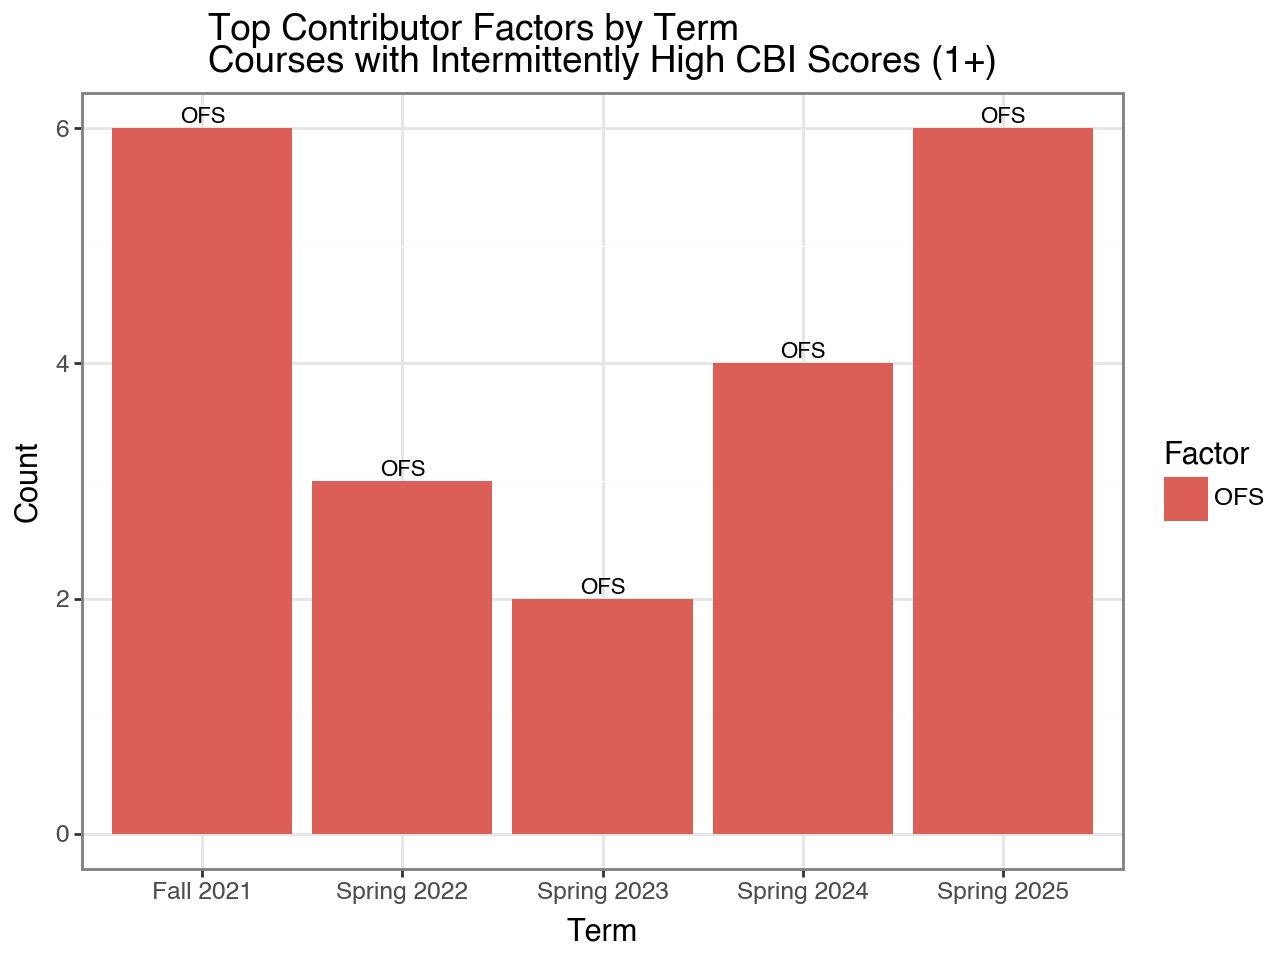

In [341]:
# New DF to store Factor Counts by Top/2nd/3rd/4th Contributor
# First - Add a column to each DF above (e.g. "Top" to top_contributor_counts_by_term) to identify in the final DF
top_contributor_countsterm_intermit1["Contributor_Level"] = "Top"
second_contributor_countsterm_intermit1["Contributor_Level"] = "Second"
third_contributor_countsterm_intermit1["Contributor_Level"] = "Third"
fourth_contributor_countsterm_intermit1["Contributor_Level"] = "Fourth"

# Concatenate the DFs, rename the old top/second/etc columns to "Factor"
cbi_contributor_countsterm_intermit1 = pd.concat([
    top_contributor_countsterm_intermit1.rename(columns={"Top_Contributor": "Factor"}),
    second_contributor_countsterm_intermit1.rename(columns={"Second_Contributor": "Factor"}),
    third_contributor_countsterm_intermit1.rename(columns={"Third_Contributor": "Factor"}),
    fourth_contributor_countsterm_intermit1.rename(columns={"Fourth_Contributor": "Factor"})], ignore_index=True)

# Graph same code as the Total Graph, except now we're just graphing one Contributor Level at a time
# Graph Top Contributor first, across Terms

graph_top_contributor_countsterm_intermit1 = (
    ggplot(cbi_contributor_countsterm_intermit1[cbi_contributor_countsterm_intermit1["Contributor_Level"] == "Top"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Top Contributor Factors by Term\nCourses with Intermittently High CBI Scores (1+)", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

graph_top_contributor_countsterm_intermit1

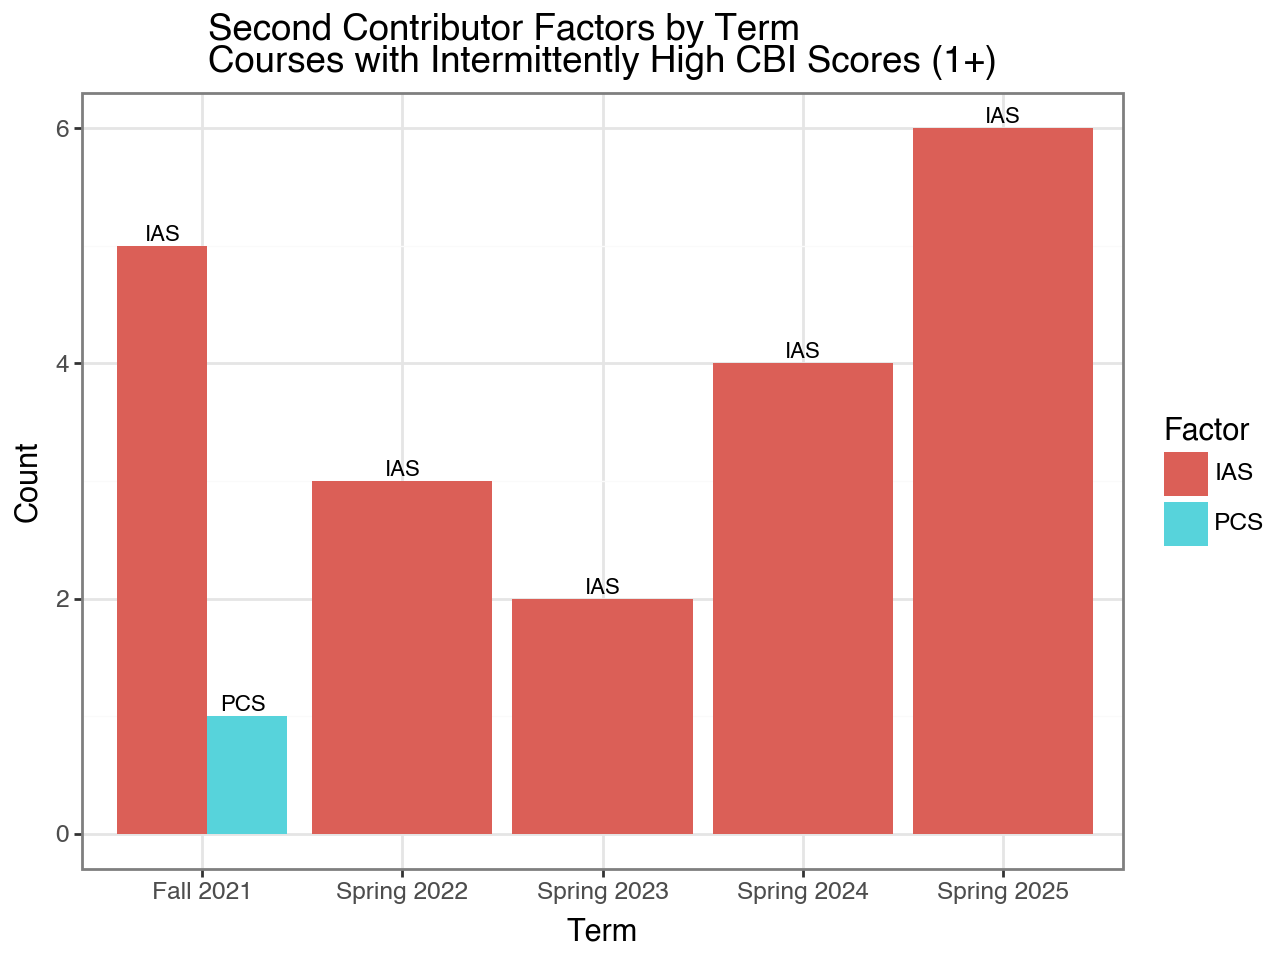

In [342]:
graph_2_contributor_countsterm_intermit1 = (
    ggplot(cbi_contributor_countsterm_intermit1[cbi_contributor_countsterm_intermit1["Contributor_Level"] == "Second"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Second Contributor Factors by Term\nCourses with Intermittently High CBI Scores (1+)", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

graph_2_contributor_countsterm_intermit1

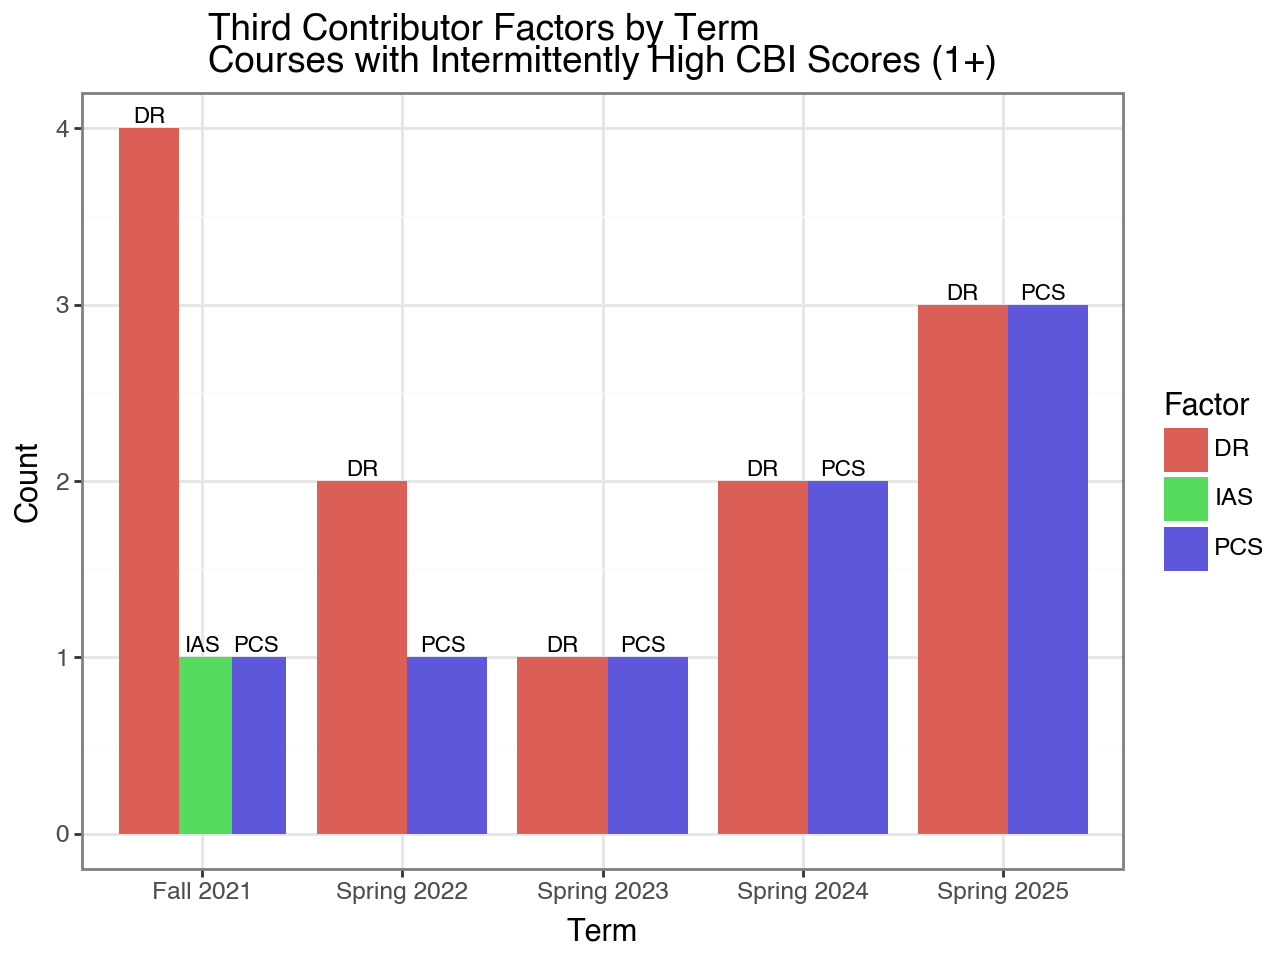

In [343]:
graph_3_contributor_countsterm_intermit1 = (
    ggplot(cbi_contributor_countsterm_intermit1[cbi_contributor_countsterm_intermit1["Contributor_Level"] == "Third"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Third Contributor Factors by Term\nCourses with Intermittently High CBI Scores (1+)", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

graph_3_contributor_countsterm_intermit1

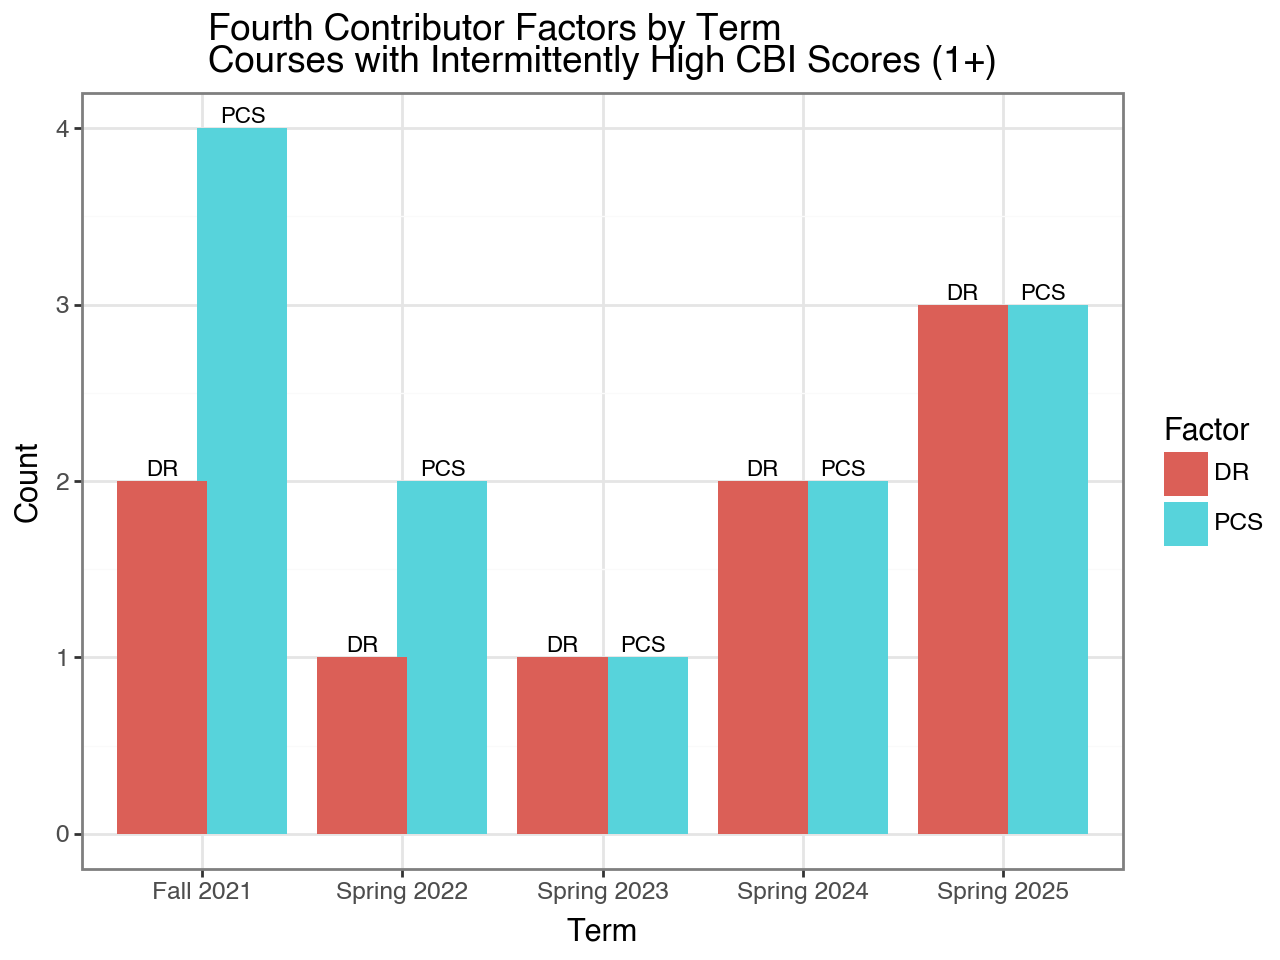

In [344]:
graph_4_contributor_countsterm_intermit1 = (
    ggplot(cbi_contributor_countsterm_intermit1[cbi_contributor_countsterm_intermit1["Contributor_Level"] == "Fourth"], 
           aes(x="Term", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +                
    theme_bw() +
    labs(title="Fourth Contributor Factors by Term\nCourses with Intermittently High CBI Scores (1+)", x="Term", y="Count") +
    theme(axis_text_x=element_text(ha='center'),legend_title=element_text(text="Factor"))
    )

graph_4_contributor_countsterm_intermit1

<h1>Suggestions by CBI</h1>

<h3>Easiest to Increase OFS: high DR & low IAS (high demand, multiple teachers)</h3>

In [345]:
CBI_tot_easy = CBI_tot.copy()

CBI_tot_easy = (CBI_tot_easy[
    (CBI_tot_easy["DR"] >= 0.33) &
    (CBI_tot_easy["IAS"] < 1) &
    (CBI_tot_easy["CBI"] > 1.5)]
    .sort_values(by="CBI", ascending=False).reset_index(drop=True))

print("The Easiest Classes to Increase Offering Frequency\n(High Demand & Multiple Teachers Available):\n")
print(CBI_tot_easy)

The Easiest Classes to Increase Offering Frequency
(High Demand & Multiple Teachers Available):

               Course Description    DR  OFS   IAS  PCS   CBI
0  Foundation of Info & Inference  0.63    3  0.50    1  2.59
1        Intro to Creative Coding  0.62    3  0.33    1  2.58
2             Advanced Web Design  0.33    3  0.33    1  2.57
3       Intro to Digital Cultures  0.52    3  0.50    0  2.23
4      Instructional Technologies  0.52    3  0.33    0  2.22
5             Installation Design  0.87    2  0.50    1  1.87
6            Algorithms for Games  0.68    2  0.50    1  1.86
7         Artificial Intelligence  0.36    2  0.50    1  1.85
8                 Neural Networks  0.63    2  0.33    1  1.85


<h3>Hiring / re-allocation suggestions: high DR & IAS (high demand, only 1 prof)</h3>

In [346]:
CBI_tot_hire = CBI_tot.copy()

CBI_tot_hire = (CBI_tot_hire[
    (CBI_tot_hire["DR"] >= 0.4) &
    (CBI_tot_hire["IAS"] == 1) &
    (CBI_tot_hire["CBI"] > 1.5)]
    .sort_values(by="CBI", ascending=False).reset_index(drop=True))

print("Hiring or Professor Re-Allocation Suggestions\n(High Demand & Only 1 Teacher):\n")
print(CBI_tot_hire)

Hiring or Professor Re-Allocation Suggestions
(High Demand & Only 1 Teacher):

              Course Description    DR  OFS  IAS  PCS   CBI
0                        Game AI  0.41    3  1.0    1  2.61
1  Monetizing Independent Gaming  0.60    3  1.0    0  2.27
2                Esports Casting  0.53    3  1.0    0  2.26
3        Visual Content Creation  0.52    3  1.0    0  2.26
4          Intro to Data Science  0.51    2  1.0    0  1.54
5          Dig Games and Society  0.40    2  1.0    0  1.53


<h3>InfoSci Recruiting suggestions (trendy tech, high CBI)</h3>

In [347]:
CBI_tot_trendy = CBI_tot.copy()
trendy_courses = ["Game AI", "Esports Casting", "Intro to Creative Coding", "Natural Language Processing", "User Interface and Website Design",
                  "STEM Games", "Computational Social Science", "Advanced Web Design", "Applied Cyberinfrastruct Conc", "Bayesian Modeling & Inference",
                  "Monetizing Independent Gaming", "Visual Content Creation", "Intro to Digital Cultures", "Installation Design", "Algorithms for Games",
                  "Artificial Intelligence", "Neural Networks", "Princ Data Science", "Intro to Data Science"]
# Trendy courses based on: CBI > 1.5, my personal opinion, and generally high DR (>0.4) scores

CBI_tot_trendy = (CBI_tot_trendy[
    (CBI_tot_trendy["CBI"] > 1.5) &
    (CBI_tot["Course Description"].isin(trendy_courses))]
    .sort_values(by="CBI", ascending=False).reset_index(drop=True))

print("InfoSci Recruiting Suggestions\n(Trendy Tech, High CBI, and generally high DR):\n")
print(CBI_tot_trendy)

InfoSci Recruiting Suggestions
(Trendy Tech, High CBI, and generally high DR):

               Course Description    DR  OFS   IAS  PCS   CBI
0                         Game AI  0.41    3  1.00    1  2.61
1                      STEM Games  0.05    3  1.00    1  2.60
2    Computational Social Science  0.01    3  1.00    1  2.59
3     Natural Language Processing  0.00    3  1.00    1  2.59
4        Intro to Creative Coding  0.62    3  0.33    1  2.58
5             Advanced Web Design  0.33    3  0.33    1  2.57
6   Bayesian Modeling & Inference  0.03    3  0.50    1  2.56
7   Applied Cyberinfrastruct Conc  0.14    3  0.33    1  2.56
8   Monetizing Independent Gaming  0.60    3  1.00    0  2.27
9                 Esports Casting  0.53    3  1.00    0  2.26
10        Visual Content Creation  0.52    3  1.00    0  2.26
11      Intro to Digital Cultures  0.52    3  0.50    0  2.23
12            Installation Design  0.87    2  0.50    1  1.87
13           Algorithms for Games  0.68    2  0.50  

<h1>Graphing for Poster</h1>

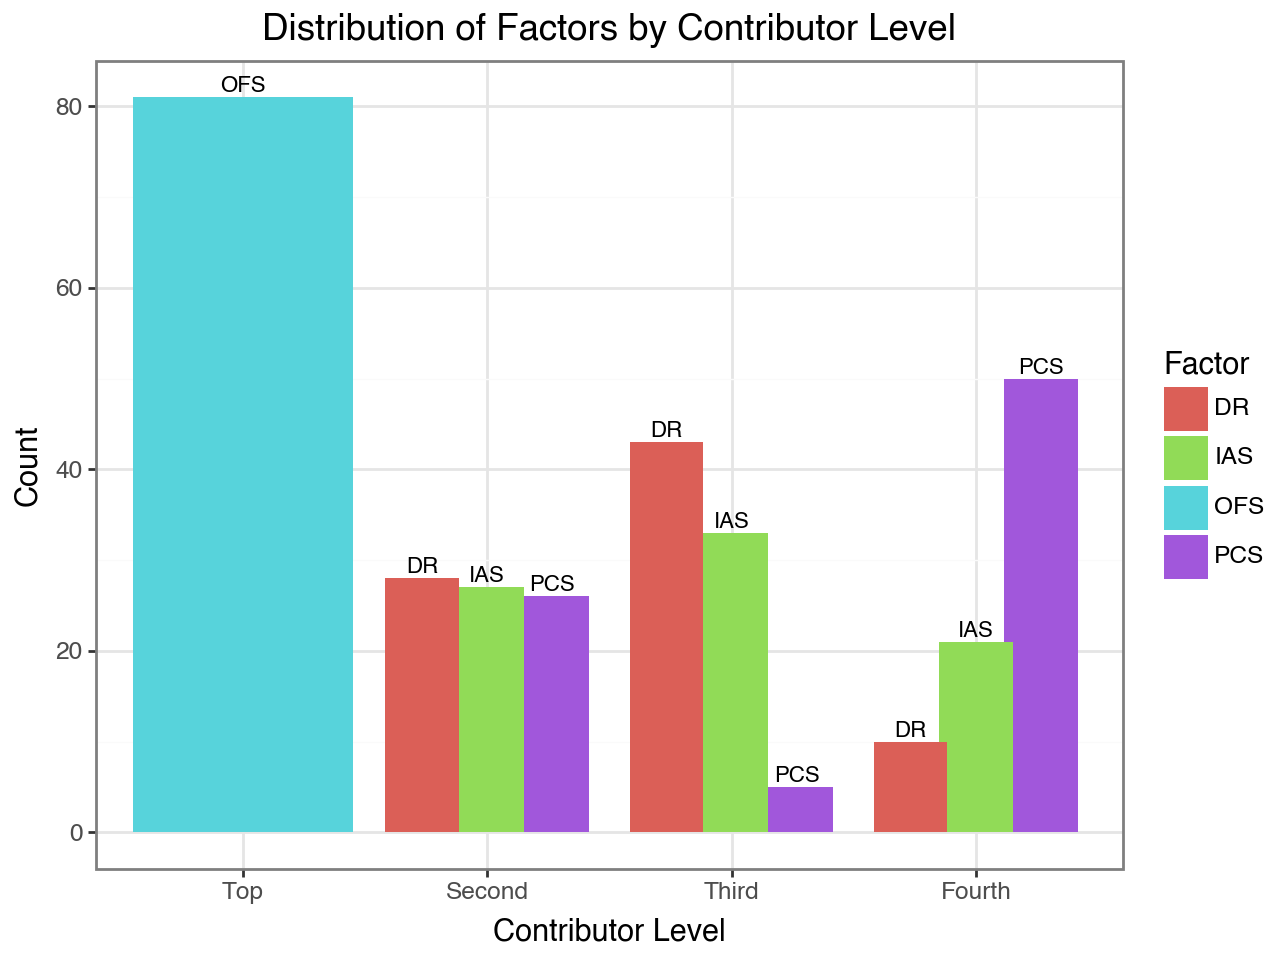

In [348]:
# original for reference
cbi_contributor_graph = (ggplot(cbi_contributor_counts, aes(x="Level", y="Count", fill="Factor")) +
                         # Grouped bar chart, use position_dodge
                         geom_bar(stat="identity", position=position_dodge(width=0.8)) +
                         # Add Factor labels on top of bars
                         geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +
                         theme_bw() +
                         labs(title="Distribution of Factors by Contributor Level", x="Contributor Level", y="Count") +
                         theme(axis_text_x=element_text(ha='center'), legend_title=element_text(text="Factor")))

cbi_contributor_graph

Custom Color Scheme

In [349]:
# Updated color palette for the 4 factors
#custom_colors = ["#354c7b",  "#9688ae", "#cc8693", "#d9dceb"] # from UA sunset photo
custom_colors = ["#345368", "#dfc2c5", "#9a6366", "#7bc4e1"] # from UA's marketing department

Factors - Total

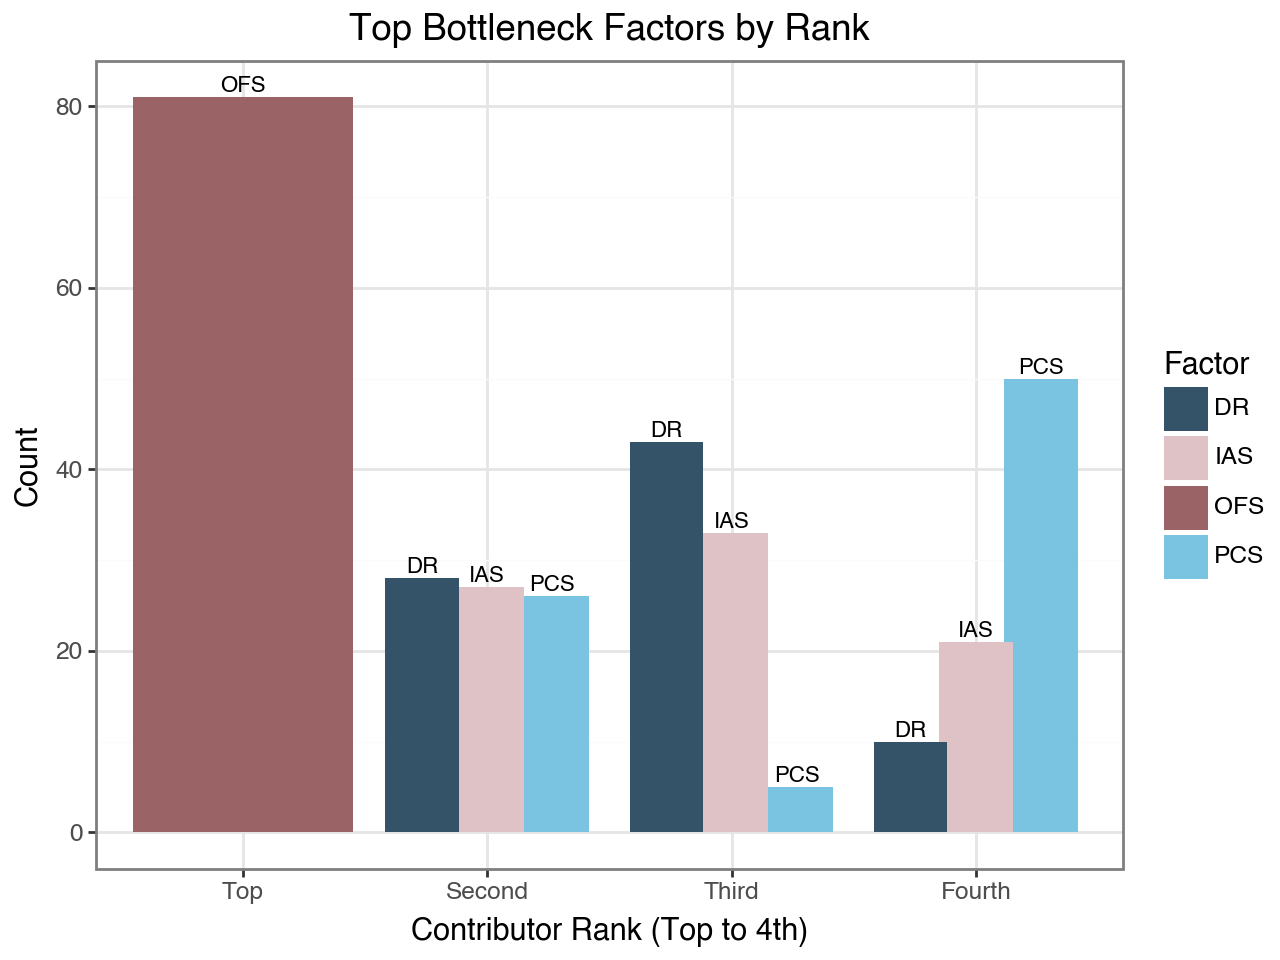

In [350]:
# Updated plot with custom color scheme
cbi_contributor_graph_custom = (
    ggplot(cbi_contributor_counts, aes(x="Level", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +
    scale_fill_manual(values=custom_colors) +  # Apply custom colors
    theme_bw() +
    labs(title="Top Bottleneck Factors by Rank", # alternate title: Factor Frequency by Contributor Rank
         x="Contributor Rank (Top to 4th)", y="Count") + 
    theme(plot_title=element_text(ha='center'), axis_text_x=element_text(ha='center'), legend_title=element_text(text="Factor"))
)

cbi_contributor_graph_custom


Factors x Persistently High

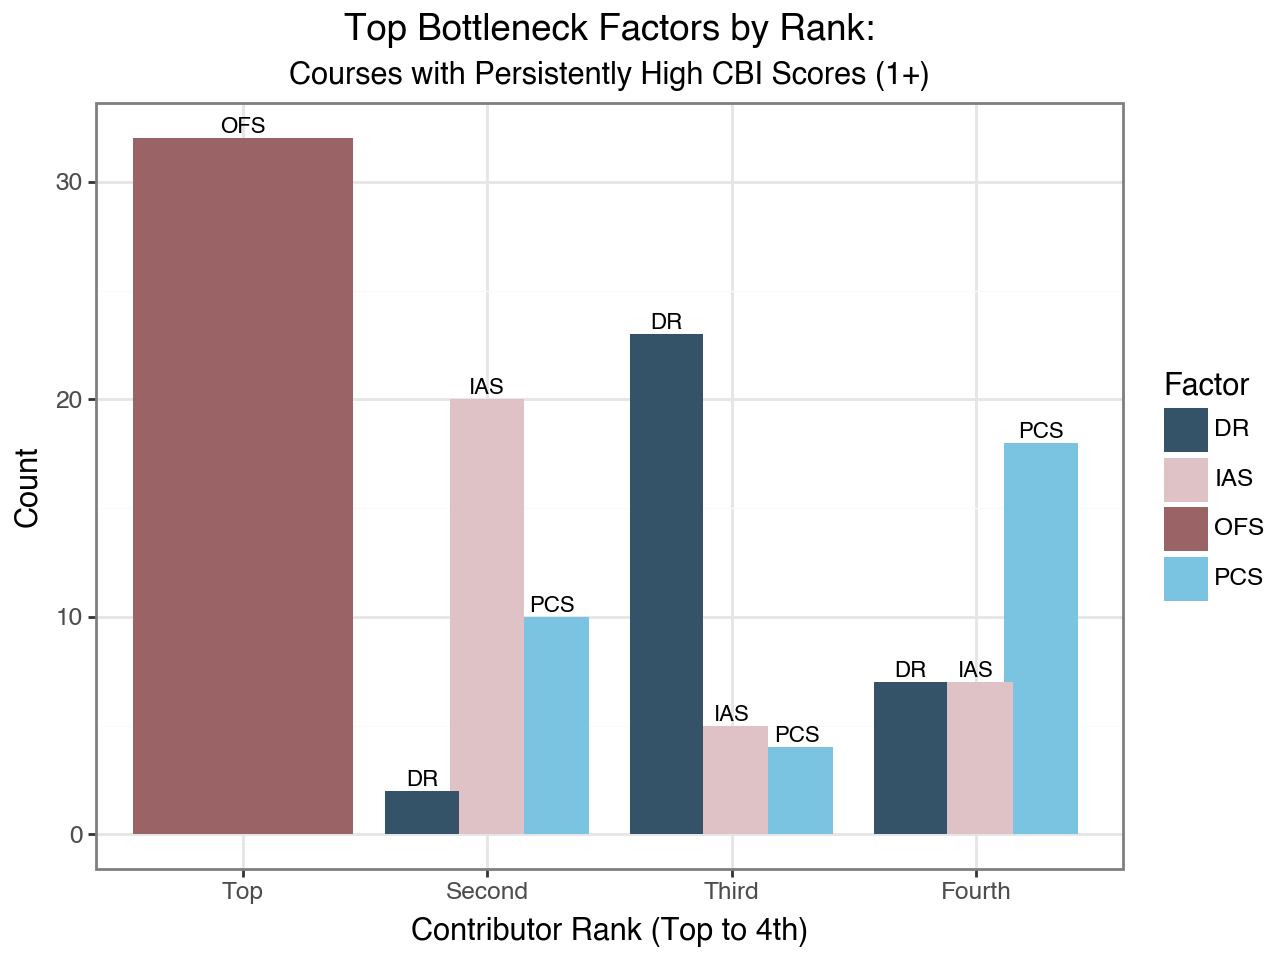

In [351]:
# New version with updated color scheme
CBI_tot_persistent_graph_1_custom = (
    ggplot(CBI_tot_persistent1_forgraphing, aes(x="Level", y="Count", fill="Factor")) +
    geom_bar(stat="identity", position=position_dodge(width=0.8)) +
    geom_text(aes(label="Factor"), position=position_dodge(width=0.8), va='bottom', size=8) +
    scale_fill_manual(values=custom_colors) +
    theme_bw() +
    labs(title="Top Bottleneck Factors by Rank:", subtitle="Courses with Persistently High CBI Scores (1+)",
        #title="        Top Bottleneck Factors by Rank:\nCourses with Persistently High CBI Scores", 
         x="Contributor Rank (Top to 4th)", y="Count") +
    theme(plot_title=element_text(ha='center'), plot_subtitle=element_text(ha='center'),
          axis_text_x=element_text(ha='center'), legend_title=element_text(text="Factor"))
)

CBI_tot_persistent_graph_1_custom

<h1>Final Exports</h1>

In [359]:
CBI_final_path = os.path.join(os.getcwd(), "CBI Analysis_Actionable Insights_Final Findings")
os.makedirs(CBI_final_path, exist_ok=True)

In [360]:
# Save CBI Total DFs
total_analysis_dfs = {
    "CBI Total with Factors - Alphabetical": CBI_tot,
    "CBI Total - High to Low CBI Score": CBI_tot_highlow1,
    "CBI Total - Top 10 Highest CBI Scores, Grouped by CBI Score": tot_top_grouped,
    "Persistently High CBI Scores (1+) - Courses & Frequency": trend_persistent_high1,
    "Persistently High CBI Scores (1.5+) - Courses & Frequency": trend_persistent_high15,
    "Intermittently High CBI Scores (1+) - Courses & Frequency": trend_intermittent2_high1,
    "Intermittently High CBI Scores (1.5+) - Courses & Frequency": trend_intermittent2_high15,
    "Persistently High CBI Scores (1+) - Courses, CBI Score, Factor Scores": CBI_tot_persistent1,
    "Persistently High CBI Scores (1.5+) - Courses, CBI Score, Factor Scores": CBI_tot_persistent15,
    "Recommendation 1 - Easiest Classes to Increase Offering Frequency": CBI_tot_easy,
    "Recommendation 2 - Hiring or Professor Re-Allocation Suggestions": CBI_tot_hire,
    "Recommendation 3 - InfoSci Recruiting Suggestions": CBI_tot_trendy 
}

for filename, df in total_analysis_dfs.items():
    full_path = os.path.join(CBI_final_path, f"{filename}.xlsx")
    df.to_excel(full_path, index=False)
    print(f"Saved: {filename}.xlsx")

Saved: CBI Total with Factors - Alphabetical.xlsx
Saved: CBI Total - High to Low CBI Score.xlsx
Saved: CBI Total - Top 10 Highest CBI Scores, Grouped by CBI Score.xlsx
Saved: Persistently High CBI Scores (1+) - Courses & Frequency.xlsx
Saved: Persistently High CBI Scores (1.5+) - Courses & Frequency.xlsx
Saved: Intermittently High CBI Scores (1+) - Courses & Frequency.xlsx
Saved: Intermittently High CBI Scores (1.5+) - Courses & Frequency.xlsx
Saved: Persistently High CBI Scores (1+) - Courses, CBI Score, Factor Scores.xlsx
Saved: Persistently High CBI Scores (1.5+) - Courses, CBI Score, Factor Scores.xlsx
Saved: Recommendation 1 - Easiest Classes to Increase Offering Frequency.xlsx
Saved: Recommendation 2 - Hiring or Professor Re-Allocation Suggestions.xlsx
Saved: Recommendation 3 - InfoSci Recruiting Suggestions.xlsx


In [361]:
# Save Summary Stats for the CBI Total KDD

# Create Word doc
summarydoc = Document()

# Summary statistics
summarydoc.add_heading('CBI Total Summary Stats', level=1)
summarydoc.add_paragraph(f"Mean CBI: {cbi_tot_mean}")
summarydoc.add_paragraph(f"Median CBI: {cbi_tot_median}")
summarydoc.add_paragraph(f"Standard Deviation: {cbi_tot_std}")
summarydoc.add_paragraph(f"Min CBI: {cbi_tot_min}")
summarydoc.add_paragraph(f"Max CBI: {cbi_tot_max}")

# Quantiles
summarydoc.add_heading('Scoring Distribution (Quantiles)', level=1)
summarydoc.add_paragraph(f"25% of the data has a CBI below: {round(q1_cbi_tot, 2)}")
summarydoc.add_paragraph(f"50% of the data has a CBI below: {round(q2_cbi_tot, 2)}")
summarydoc.add_paragraph(f"75% of the data has a CBI below: {round(q3_cbi_tot, 2)}")


# Top 10
summarydoc.add_heading('Top 10 Highest CBI Courses', level=1)
for i, row in top_cbi_tot.iterrows():
    summarydoc.add_paragraph(f"{row['Course Description']}: {round(row['CBI'], 2)}")

# Bottom 10
summarydoc.add_heading('Bottom 10 Lowest CBI Courses', level=1)
for i, row in bottom_cbi_tot.iterrows():
    summarydoc.add_paragraph(f"{row['Course Description']}: {round(row['CBI'], 2)}")

# Save the document
summarydoc.save(os.path.join(CBI_final_path, "CBI Total - Summary Stats.docx"))

In [362]:
# Save graphs
graph_dict = {
    "Total - All - Factors by Rank": cbi_contributor_graph,
    "Total - Persistently High (1.5+) - Factors by Rank": CBI_tot_persistent_graph_15,
    "Total - Persistently High (1+) - Factors by Rank": CBI_tot_persistent_graph_1,
    "Total - Intermittently High (1+) - Factors by Rank": CBI_tot_intermittent_graph_1,
}

for filename, plot in graph_dict.items():
    filepath = os.path.join(CBI_final_path, f"{filename}.png")
    plot.save(filename=filepath, dpi=300)  
    print(f"Saved: {filename}.png\n")

/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Total - All - Factors by Rank.png


Saved: Total - All - Factors by Rank.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Total - Persistently High (1.5+) - Factors by Rank.png


Saved: Total - Persistently High (1.5+) - Factors by Rank.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Total - Persistently High (1+) - Factors by Rank.png


Saved: Total - Persistently High (1+) - Factors by Rank.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Total - Intermittently High (1+) - Factors by Rank.png


Saved: Total - Intermittently High (1+) - Factors by Rank.png



In [363]:
# Save Poster Graphs
cbi_contributor_graph_custom.save(
    filename=os.path.join(CBI_final_path, "Poster - Top Bottleneck Factors by Rank.png"),
    dpi=300, width=10, height=6, units="in")

CBI_tot_persistent_graph_1_custom.save(
    filename=os.path.join(CBI_final_path, "Poster - Top Bottleneck Factors by Rank x High CBI scores.png"),
    dpi=300, width=10, height=6, units="in")


/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Poster - Top Bottleneck Factors by Rank.png
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Poster - Top Bottleneck Factors by Rank x High CBI scores.png


In [364]:
#Extra folder for our by Term Graphs
# Create subfolder path
extra_byterm_path = os.path.join(CBI_final_path, "Extra_By Term Analysis Graphs")
os.makedirs(extra_byterm_path, exist_ok=True)

# Save By Term graphs
graph_dict_term = {
    "By Term - All - #1 Contributors": cbi_contributor_graph_term_top,
    "By Term - All - #2 Contributors": cbi_contributor_graph_term_2nd,
    "By Term - All - #3 Contributors": cbi_contributor_graph_term_3rd,
    "By Term - All - #4 Contributors": cbi_contributor_graph_term_4th,

    "By Term - Persistently High (1+) - #1 Contributors": graph_top_contributor_countsterm_persistent1,
    "By Term - Persistently High (1+) - #2 Contributors": graph_2nd_contributor_countsterm_persistent1,
    "By Term - Persistently High (1+) - #3 Contributors": graph_3rd_contributor_countsterm_persistent1,
    "By Term - Persistently High (1+) - #4 Contributors": graph_4th_contributor_countsterm_persistent1,

    "By Term - Intermittently High (1+) - #1 Contributors": graph_top_contributor_countsterm_intermit1,
    "By Term - Intermittently High (1+) - #2 Contributors": graph_2_contributor_countsterm_intermit1,
    "By Term - Intermittently High (1+) - #3 Contributors": graph_3_contributor_countsterm_intermit1,
    "By Term - Intermittently High (1+) - #4 Contributors": graph_4_contributor_countsterm_intermit1
}

for filename, plot in graph_dict_term.items():
    filepath = os.path.join(extra_byterm_path, f"{filename}.png")
    plot.save(filename=filepath, dpi=300)  
    print(f"Saved: {filename}.png\n")

/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - All - #1 Contributors.png


Saved: By Term - All - #1 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - All - #2 Contributors.png


Saved: By Term - All - #2 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - All - #3 Contributors.png


Saved: By Term - All - #3 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - All - #4 Contributors.png


Saved: By Term - All - #4 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - Persistently High (1+) - #1 Contributors.png


Saved: By Term - Persistently High (1+) - #1 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - Persistently High (1+) - #2 Contributors.png


Saved: By Term - Persistently High (1+) - #2 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - Persistently High (1+) - #3 Contributors.png


Saved: By Term - Persistently High (1+) - #3 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - Persistently High (1+) - #4 Contributors.png


Saved: By Term - Persistently High (1+) - #4 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - Intermittently High (1+) - #1 Contributors.png


Saved: By Term - Intermittently High (1+) - #1 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - Intermittently High (1+) - #2 Contributors.png


Saved: By Term - Intermittently High (1+) - #2 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - Intermittently High (1+) - #3 Contributors.png


Saved: By Term - Intermittently High (1+) - #3 Contributors.png



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/morgangodley/Documents/UA Masters degree/INFO 698 Capstone/Visual Studio Code_Jupyter Notebooks/CBI Analysis_Actionable Insights_Final Findings/Extra_By Term Analysis Graphs/By Term - Intermittently High (1+) - #4 Contributors.png


Saved: By Term - Intermittently High (1+) - #4 Contributors.png

